# Training Set Aquisition

## Gregor Fritz and Laurenz Hundgeburth, FH Kärnten Bachelorprojekt

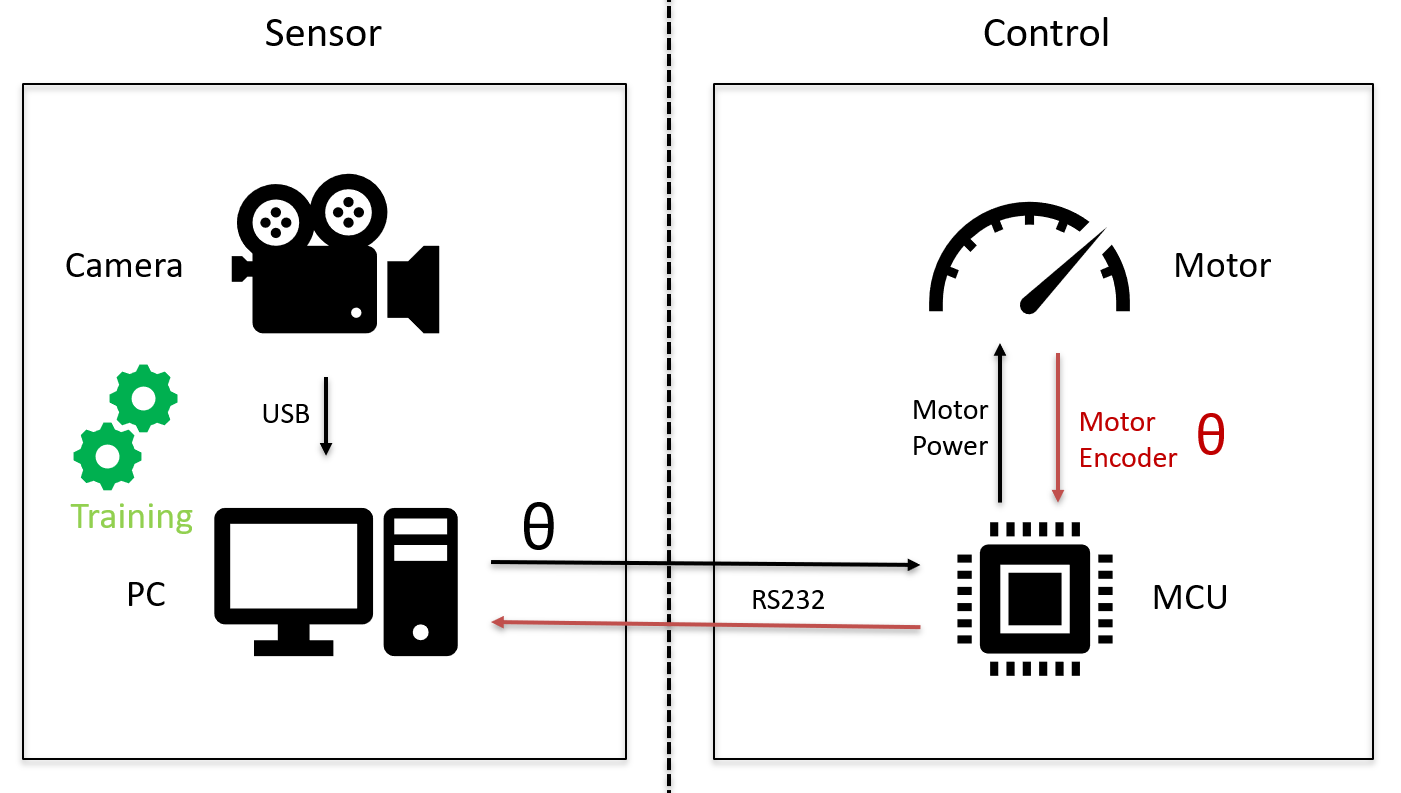

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import csv
import struct
from time import time, sleep
from serial import Serial
from random import randint
from threading import Thread
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline

In [35]:
#Class and Function Definitions

################################################################
#Serial Thread

class Ser(Thread):
    def __init__(self, port):
        super().__init__()
        self._run = True
        self._ser = Serial(port ,115200)
        self._last_value = 0.0
        self._reference = 0.0
        self._expected_reference = 0.0
        self._valid = False

    def get_act_value(self):
        return self._last_value
    
    def value_valid(self):
        return self._valid
    
    def increase_reference(self, random_rad):
        self._expected_reference += random_rad
        self._expected_reference = round(self._expected_reference, 2)
        

    def write_reference(self):
        self._ser.write(str(self._expected_reference).encode('utf-8'))
        self._ser.write('\r\n'.encode('utf-8'))

    def reference_accepted(self):
        return self._expected_reference == self._reference

    def run(self):
        print('Serial Thread running')
        while self._run:
            line = self._ser.readline()
            data = line.split(b',')
            try:
                if len(data) == 3:
                    self._valid = bool(int(data[0]))
                    self._last_value = float(data[1])
                    self._reference = float(data[2])
                    print(self._valid, self._last_value, self._reference)
                else:
                    raise ValueError
            except ValueError:
                self._last_value = None
                self._reference = None
                self._valid = False

    def end(self):
        self._run = False
        self.join()
        self._ser.close()
        
################################################################
#Camera Thread

class PsEye(Thread):
    def __init__(self):
        super().__init__()
        self._run = True
        self._video = cv2.VideoCapture(0)
        self._last_frame = None

    def get_act_frame(self):
        return self._last_frame

    def run(self):
        while self._run:
            check, frame = self._video.read()
            if check:
                self._last_frame = frame

    def save_last_frame(self, img_file_path, img_name):
        #print('Saving img {}'.format(img_name))
        cv2.imwrite(str(img_file_path + img_name), self._last_frame)

    def end(self):
        self._run = False
        self.join()
        self._video.release()

    def frame_valid(self):
        return self._last_frame is not None

################################################################
#Main Functions

def get_label_value():
    for attempt in range(10):
        if ser.value_valid():
            repeat = False
            label = ser.get_act_value()
            label =round(label %(2*np.pi), 2)
            #print("got label {}".format(str(label)))
            return (True, label)
        sleep(0.01)
    #print("No valid value")
    return (False, None)     
    
def log_csv(file, img_name, label):
    with open(file, 'a') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow([img_name, label])
    pass

Starting Camera Thread...
Camera Thread running...
closing Threads...


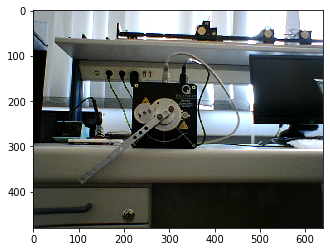

In [36]:
#Camera Image Test
print("Starting Camera Thread...")
camera = PsEye()
camera.start()

# Waiting until camera ready
while not camera.frame_valid():
    sleep(0.05)

print('Camera Thread running...')

camera.save_last_frame('./', 'test_image.png')

camera.end()
print("closing Threads...")

img=mpimg.imread('test_image.png')
imgplot = plt.imshow(img)

In [37]:
#Available Ports:
!python -m serial.tools.list_ports

/dev/ttyACM0        
/dev/ttyACM1        
2 ports found


In [38]:
#create new Folder and prepare csv
!mkdir pictures_28_6_19

In [ ]:
#create csv 
csvData = [['id', 'label']]

with open('image_labels_28_6_19.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

In [39]:
#Main Programm

port = '/dev/ttyACM1'

csv_file_path = "./image_labels_28_6_19.csv"
img_file_path = "./pictures_28_6_19/"

num_images = 300

print("#Starting Data Acquisition  -  {} images".format(str(num_images)))
print("#    csv_file_path: {}".format(csv_file_path))
print("#    img_file_path: {}".format(img_file_path))
print("#################################################")

print("Starting Serial Thread...")
ser = Ser(port)
ser.start()
sleep(1)

print("Starting Camera Thread...")
camera = PsEye()
camera.start()

# Waiting until camera ready
while not camera.frame_valid():
    sleep(0.05)

print('Camera Thread running...')

img_counter = 0
labels = []

sleep(0.3)

for a in tqdm(range(num_images)):
    #clear_output(wait=True)
    rand_increment = randint(50,80) 
    rand_rad = rand_increment/4096 * (2*np.pi)
    counter = 0
    attempt_invalid = False
    ser.increase_reference(rand_rad)
    while True:
        if not ser.reference_accepted():
            ser.write_reference()
            sleep(0.010)
        else:
            break
        
        counter += 1
        if counter >= 20: # 200 Milliseconds
            attempt_invalid = True
            break
    
    if not attempt_invalid:
        counter = 0
        while True:
            if ser.value_valid():
                break
            
            sleep(0.01)
            counter += 1
            if counter >= 200: # 2 Seconds
                attempt_invalid = True
                break
    
    (success, label) = get_label_value()
    if success and not attempt_invalid:
        img_name = "{}_{}.png".format(time(), label)
        camera.save_last_frame(img_file_path, img_name)
        log_csv(csv_file_path, img_name, label)
        img_counter += 1
        #print('attempt {} successful!'.format(a+1))
        labels.append(label)
    else:
        pass
        #print('attempt {} FAILED!'.format(a+1))
        
print("#################################################")
print("#{} out of {} attempts successful".format(img_counter, num_images))
camera.end()
ser.end()
print("#closing Threads...")

#Starting Data Acquisition  -  300 images
#    csv_file_path: ./image_labels_28_6_19.csv
#    img_file_path: ./pictures_28_6_19/
#################################################
Starting Serial Thread...
Serial Thread running
Starting Camera Thread...
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
Camera Thread running...
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.0
False 0.0 0.1
False 0.0 0.1
False 0.02 0.1
False 0.04 0.1
False 0.06 0.1
False 0.08 0.1
False 0.1 0.1
False 0.12 0.1
False 0.12 0.1
False 0.13 0.1
False 0.13 0.1
False 0.13 0.1
False 0.13 0.1
False 0.13 0.1
False 0.12 0.1
False 0.12 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.

  0%|          | 1/300 [00:02<11:01,  2.21s/it]

False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.1
False 0.11 0.22
False 0.11 0.22
False 0.13 0.22
False 0.15 0.22
False 0.17 0.22
False 0.2 0.22
False 0.22 0.22
False 0.23 0.22
False 0.25 0.22
False 0.25 0.22
False 0.26 0.22
False 0.26 0.22
False 0.25 0.22
False 0.25 0.22
False 0.24 0.22
False 0.24 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 

  1%|          | 2/300 [00:04<11:01,  2.22s/it]

False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.22
False 0.23 0.31
False 0.23 0.31
False 0.24 0.31
False 0.26 0.31
False 0.28 0.31
False 0.29 0.31
False 0.31 0.31
False 0.32 0.31
False 0.33 0.31
False 0.33 0.31
False 0.34 0.31
False 0.34 0.31
False 0.33 0.31
False 0.33 0.31
False 0.33 0.31
False 0.33 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.32 0.31
False 0.

  1%|          | 3/300 [00:06<11:04,  2.24s/it]

False 0.32 0.31
False 0.32 0.31
False 0.32 0.39
False 0.32 0.39
False 0.33 0.39
False 0.34 0.39
False 0.36 0.39
False 0.37 0.39
False 0.39 0.39
False 0.4 0.39
False 0.4 0.39
False 0.41 0.39
False 0.41 0.39
False 0.41 0.39
False 0.41 0.39
False 0.41 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0

  1%|▏         | 4/300 [00:09<11:09,  2.26s/it]

False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.39
False 0.4 0.51
False 0.4 0.51
False 0.42 0.51
False 0.44 0.51
False 0.46 0.51
False 0.48 0.51
False 0.51 0.51
False 0.52 0.51
False 0.54 0.51
False 0.54 0.51
False 0.54 0.51
False 0.54 0.51
False 0.54 0.51
False 0.54 0.51
False 0.53 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 

  2%|▏         | 5/300 [00:11<11:17,  2.29s/it]

False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.51
False 0.52 0.6
False 0.52 0.6
False 0.53 0.6
False 0.54 0.6
False 0.56 0.6
False 0.58 0.6
False 0.6 0.6
False 0.61 0.6
False 0.62 0.6
False 0.62 0.6
False 0.62 0.6
False 0.62 0.6
False 0.62 0.6
False 0.62 0.6
False 0.62 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 

  2%|▏         | 6/300 [00:13<11:13,  2.29s/it]

False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.6
False 0.61 0.7
False 0.61 0.7
False 0.62 0.7
False 0.64 0.7
False 0.66 0.7
False 0.68 0.7
False 0.69 0.7
False 0.71 0.7
False 0.72 0.7
False 0.72 0.7
False 0.73 0.7
False 0.73 0.7
False 0.72 0.7
False 0.72 0.7
False 0.72 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71

  2%|▏         | 7/300 [00:16<11:19,  2.32s/it]

False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.7
False 0.71 0.81
False 0.71 0.81
False 0.72 0.81
False 0.74 0.81
False 0.76 0.81
False 0.78 0.81
False 0.8 0.81
False 0.82 0.81
False 0.83 0.81
False 0.84 0.81
False 0.84 0.81
False 0.84 0.81
False 0.84 0.81
False 0.83 0.81
False 0.83 0.81
False 0.82 0.81
False 0.82 0.81
False 0.81 0.81
False 0.81 0.81
False 0.81 0.81
False 0.81 0.81
False 0.81 0.81
False 0.81 0.81


  3%|▎         | 8/300 [00:16<08:23,  1.73s/it]

False 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
True 0.81 0.81
False 0.81 0.9
False 0.81 0.9
False 0.83 0.9
False 0.84 0.9
False 0.86 0.9
False 0.88 0.9
False 0.89 0.9
False 0.91 0.9
False 0.92 0.9
False 0.92 0.9
False 0.92 0.9
False 0.92 0.9
False 0.92 0.9
False 0.92 0.9
False 0.91 0.9
False 0.91 0.9
False 0.91 0.9
False 0.9 0.9
False 0.9 0.9
False 0.9 0.9
False 0.9 0.9
False 0.9 0.9
False 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9


  3%|▎         | 9/300 [00:16<06:23,  1.32s/it]

True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
True 0.9 0.9
False 0.9 1.01
False 0.91 1.01
False 0.92 1.01
False 0.94 1.01
False 0.96 1.01
False 0.98 1.01
False 1.0 1.01
False 1.02 1.01
False 1.03 1.01
False 1.04 1.01
False 1.04 1.01
False 1.04 1.01
False 1.03 1.01
False 1.03 1.01
False 1.02 1.01
False 1.02 1.01
False 1.01 1.01
False 1.01 1.01
False 1.01 1.01
False 1.01 1.01
False 1.01 1.01
False 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01
True 1.01 1.01


  3%|▎         | 10/300 [00:17<04:59,  1.03s/it]

True 1.01 1.01
True 1.01 1.01
False 1.01 1.1
False 1.01 1.1
False 1.02 1.1
False 1.04 1.1
False 1.06 1.1
False 1.07 1.1
False 1.09 1.1
False 1.11 1.1
False 1.12 1.1
False 1.12 1.1
False 1.12 1.1
False 1.12 1.1
False 1.12 1.1
False 1.12 1.1
False 1.11 1.1
False 1.11 1.1
False 1.1 1.1
False 1.1 1.1
False 1.1 1.1


  4%|▎         | 11/300 [00:17<03:57,  1.22it/s]

False 1.1 1.1
False 1.1 1.1
False 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
True 1.1 1.1
False 1.1 1.2
False 1.1 1.2
False 1.12 1.2
False 1.13 1.2
False 1.15 1.2
False 1.17 1.2
False 1.19 1.2
False 1.21 1.2
False 1.22 1.2
False 1.22 1.2
False 1.22 1.2
False 1.22 1.2
False 1.22 1.2
False 1.21 1.2
False 1.21 1.2
False 1.21 1.2
False 1.2 1.2
False 1.2 1.2
False 1.2 1.2
False 1.2 1.2
False 1.2 1.2
False 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2


  4%|▍         | 12/300 [00:17<03:16,  1.47it/s]

True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
True 1.2 1.2
False 1.2 1.29
False 1.2 1.29
False 1.21 1.29
False 1.23 1.29
False 1.25 1.29
False 1.26 1.29
False 1.28 1.29
False 1.29 1.29
False 1.3 1.29
False 1.3 1.29
False 1.31 1.29
False 1.31 1.29
False 1.31 1.29
False 1.3 1.29
False 1.3 1.29
False 1.3 1.29
False 1.29 1.29
False 1.29 1.29
False 1.29 1.29
False 1.29 1.29
False 1.29 1.29
False 1.29 1.29
False 1.29 1.29
False 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29


  4%|▍         | 13/300 [00:18<02:49,  1.69it/s]

True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
True 1.29 1.29
False 1.29 1.39
False 1.3 1.39
False 1.31 1.39
False 1.32 1.39
False 1.34 1.39
False 1.36 1.39
False 1.38 1.39
False 1.39 1.39
False 1.4 1.39
False 1.41 1.39
False 1.41 1.39
False 1.41 1.39
False 1.41 1.39
False 1.4 1.39
False 1.4 1.39
False 1.4 1.39


  5%|▍         | 14/300 [00:18<02:24,  1.98it/s]

False 1.39 1.39
False 1.39 1.39
False 1.39 1.39
False 1.39 1.39
False 1.39 1.39
False 1.39 1.39
False 1.39 1.39
False 1.39 1.39
True 1.39 1.39
True 1.39 1.39
True 1.39 1.39
True 1.39 1.39
True 1.39 1.39
True 1.39 1.39
True 1.39 1.39
False 1.39 1.5
False 1.39 1.5
False 1.41 1.5
False 1.43 1.5
False 1.45 1.5
False 1.47 1.5
False 1.49 1.5
False 1.5 1.5
False 1.51 1.5
False 1.52 1.5
False 1.52 1.5
False 1.52 1.5
False 1.52 1.5
False 1.51 1.5
False 1.51 1.5
False 1.51 1.5
False 1.5 1.5
False 1.5 1.5
False 1.5 1.5
False 1.5 1.5
False 1.5 1.5
False 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5


  5%|▌         | 15/300 [00:18<02:12,  2.15it/s]

True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
True 1.5 1.5
False 1.5 1.59
False 1.5 1.59
False 1.51 1.59
False 1.53 1.59
False 1.54 1.59
False 1.56 1.59
False 1.58 1.59
False 1.59 1.59
False 1.6 1.59
False 1.6 1.59
False 1.6 1.59
False 1.6 1.59
False 1.6 1.59


  5%|▌         | 16/300 [00:19<01:58,  2.39it/s]

False 1.6 1.59
False 1.6 1.59
False 1.6 1.59
False 1.59 1.59
False 1.59 1.59
False 1.59 1.59
False 1.59 1.59
False 1.59 1.59
False 1.59 1.59
True 1.59 1.59
True 1.59 1.59
True 1.59 1.59
True 1.59 1.59
True 1.59 1.59
True 1.59 1.59
True 1.59 1.59
True 1.59 1.59
False 1.59 1.71
False 1.59 1.71
False 1.61 1.71
False 1.63 1.71
False 1.65 1.71
False 1.68 1.71
False 1.7 1.71
False 1.71 1.71
False 1.72 1.71
False 1.73 1.71
False 1.73 1.71
False 1.73 1.71
False 1.73 1.71
False 1.72 1.71
False 1.72 1.71
False 1.72 1.71
False 1.71 1.71
False 1.71 1.71
False 1.71 1.71
False 1.71 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71


  6%|▌         | 17/300 [00:21<04:34,  1.03it/s]

False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.71
False 1.7 1.83
False 1.71 1.83
False 1.72 1.83
False 1.74 1.83
False 1.77 1.83
False 1.79 1.83
False 1.81 1.83
False 1.83 1.83
False 1.84 1.83
False 1.85 1.83
False 1.85 1.83
False 1.85 1.83
False 1.85 1.83
False 1.85 1.83
False 1.84 1.83
False 1.84 1.83
False 1.83 1.83
False 1.83 1.83
False 1.83 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
F

  6%|▌         | 18/300 [00:23<06:21,  1.35s/it]

False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.83
False 1.82 1.95
False 1.82 1.95
False 1.84 1.95
False 1.86 1.95
False 1.89 1.95
False 1.91 1.95
False 1.93 1.95
False 1.95 1.95
False 1.96 1.95
False 1.97 1.95
False 1.97 1.95
False 1.97 1.95
False 1.97 1.95
False 1.97 1.95
False 1.96 1.95
False 1.96 1.95
False 1.95 1.95
False 1.95 1.95
False 1.95 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.

  6%|▋         | 19/300 [00:25<07:32,  1.61s/it]

False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 1.95
False 1.94 2.03
False 1.94 2.03
False 1.95 2.03
False 1.97 2.03
False 1.98 2.03
False 2.0 2.03
False 2.01 2.03
False 2.02 2.03
False 2.03 2.03


  7%|▋         | 20/300 [00:26<05:37,  1.20s/it]

False 2.04 2.03
False 2.04 2.03
False 2.04 2.03
False 2.04 2.03
False 2.04 2.03
False 2.03 2.03
False 2.03 2.03
False 2.03 2.03
False 2.03 2.03
False 2.03 2.03
True 2.03 2.03
True 2.03 2.03
True 2.03 2.03
True 2.02 2.03
False 2.02 2.03
False 2.02 2.03
False 2.02 2.03
False 2.02 2.13
False 2.02 2.13
False 2.04 2.13
False 2.05 2.13
False 2.07 2.13
False 2.09 2.13
False 2.11 2.13
False 2.13 2.13
False 2.14 2.13
False 2.14 2.13
False 2.15 2.13
False 2.15 2.13
False 2.14 2.13
False 2.14 2.13
False 2.14 2.13
False 2.13 2.13
False 2.13 2.13
False 2.13 2.13
False 2.13 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2

  7%|▋         | 21/300 [00:28<07:03,  1.52s/it]

False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.13
False 2.12 2.24
False 2.12 2.24
False 2.14 2.24
False 2.16 2.24
False 2.18 2.24
False 2.2 2.24
False 2.22 2.24
False 2.24 2.24
False 2.25 2.24
False 2.25 2.24
False 2.26 2.24
False 2.26 2.24
False 2.26 2.24
False 2.25 2.24
False 2.25 2.24
False 2.24 2.24
False 2.24 2.24
False 2.24 2.24
False 2.24 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.2

  7%|▋         | 22/300 [00:30<08:04,  1.74s/it]

False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.24
False 2.23 2.32
False 2.23 2.32
False 2.24 2.32
False 2.26 2.32
False 2.27 2.32
False 2.29 2.32


  8%|▊         | 23/300 [00:30<05:59,  1.30s/it]

False 2.3 2.32
False 2.31 2.32
False 2.32 2.32
False 2.33 2.32
False 2.33 2.32
False 2.33 2.32
False 2.33 2.32
False 2.33 2.32
False 2.32 2.32
False 2.32 2.32
False 2.32 2.32
False 2.32 2.32
False 2.32 2.32
True 2.32 2.32
True 2.32 2.32
True 2.31 2.32
True 2.31 2.32
False 2.31 2.32
False 2.31 2.32
False 2.31 2.32
False 2.31 2.32
False 2.31 2.32
False 2.31 2.42
False 2.31 2.42
False 2.33 2.42
False 2.35 2.42
False 2.37 2.42
False 2.39 2.42
False 2.4 2.42
False 2.42 2.42
False 2.43 2.42
False 2.43 2.42
False 2.44 2.42
False 2.44 2.42
False 2.43 2.42
False 2.43 2.42
False 2.43 2.42
False 2.42 2.42
False 2.42 2.42
False 2.42 2.42
False 2.42 2.42
False 2.41 2.42
True 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42

  8%|▊         | 24/300 [00:33<07:20,  1.60s/it]

False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.42
False 2.41 2.53
False 2.41 2.53
False 2.43 2.53
False 2.45 2.53
False 2.47 2.53
False 2.49 2.53
False 2.51 2.53
False 2.53 2.53
False 2.54 2.53
False 2.54 2.53
False 2.55 2.53
False 2.55 2.53
False 2.55 2.53
False 2.54 2.53
False 2.54 2.53
False 2.53 2.53
False 2.53 2.53
False 2.53 2.53
False 2.53 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.

  8%|▊         | 25/300 [00:35<08:08,  1.78s/it]

 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.53
False 2.52 2.64
False 2.52 2.64
False 2.54 2.64
False 2.56 2.64
False 2.58 2.64
False 2.6 2.64
False 2.62 2.64
False 2.64 2.64
False 2.65 2.64
False 2.66 2.64
False 2.66 2.64
False 2.66 2.64
False 2.66 2.64
False 2.65 2.64
False 2.65 2.64
False 2.64 2.64
False 2.64 2.64
False 2.64 2.64
False 2.64 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.6

  9%|▊         | 26/300 [00:37<08:46,  1.92s/it]

False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.64
False 2.63 2.75
False 2.63 2.75
False 2.65 2.75
False 2.67 2.75
False 2.69 2.75
False 2.71 2.75
False 2.73 2.75
False 2.75 2.75
False 2.76 2.75
False 2.77 2.75
False 2.77 2.75
False 2.77 2.75
False 2.77 2.75
False 2.76 2.75
False 2.76 2.75
False 2.76 2.75
False 2.75 2.75
False 2.75 2.75
False 2.75 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.

  9%|▉         | 27/300 [00:39<09:13,  2.03s/it]

False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.75
False 2.74 2.87
False 2.74 2.87
False 2.76 2.87
False 2.78 2.87
False 2.8 2.87
False 2.83 2.87
False 2.85 2.87
False 2.87 2.87
False 2.88 2.87
False 2.89 2.87
False 2.89 2.87
False 2.89 2.87
False 2.89 2.87
False 2.89 2.87
False 2.88 2.87
False 2.88 2.87
False 2.87 2.87
False 2.87 2.87
False 2.87 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.8

  9%|▉         | 28/300 [00:42<09:29,  2.10s/it]

False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.87
False 2.86 2.97
False 2.86 2.97
False 2.88 2.97
False 2.89 2.97
False 2.91 2.97


 10%|▉         | 29/300 [00:42<07:00,  1.55s/it]

False 2.93 2.97
False 2.95 2.97
False 2.97 2.97
False 2.98 2.97
False 2.98 2.97
False 2.99 2.97
False 2.99 2.97
False 2.99 2.97
False 2.98 2.97
False 2.98 2.97
False 2.98 2.97
False 2.97 2.97
False 2.97 2.97
False 2.97 2.97
False 2.97 2.97
True 2.97 2.97
True 2.96 2.97
True 2.96 2.97
False 2.96 2.97
False 2.96 2.97
False 2.96 2.97
False 2.96 2.97
False 2.96 2.97
False 2.96 2.97
False 2.96 3.06
False 2.96 3.06
False 2.98 3.06
False 2.99 3.06
False 3.01 3.06
False 3.03 3.06
False 3.04 3.06
False 3.06 3.06
False 3.07 3.06
False 3.07 3.06
False 3.07 3.06
False 3.07 3.06
False 3.07 3.06
False 3.07 3.06
False 3.07 3.06
False 3.07 3.06
False 3.06 3.06
False 3.06 3.06
False 3.06 3.06


 10%|█         | 30/300 [00:42<05:17,  1.18s/it]

False 3.06 3.06
False 3.06 3.06
True 3.06 3.06
True 3.06 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
True 3.05 3.06
False 3.05 3.14
False 3.06 3.14
False 3.06 3.14
False 3.08 3.14
False 3.1 3.14
False 3.11 3.14
False 3.12 3.14
False 3.14 3.14


 10%|█         | 31/300 [00:43<04:07,  1.09it/s]

False 3.14 3.14
False 3.15 3.14
False 3.15 3.14
False 3.15 3.14
False 3.15 3.14
False 3.15 3.14
False 3.15 3.14
False 3.14 3.14
False 3.14 3.14
False 3.14 3.14
False 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
True 3.14 3.14
False 3.13 3.22
False 3.14 3.22
False 3.15 3.22
False 3.16 3.22
False 3.18 3.22
False 3.19 3.22
False 3.2 3.22
False 3.22 3.22
False 3.22 3.22
False 3.23 3.22
False 3.23 3.22
False 3.23 3.22
False 3.23 3.22
False 3.23 3.22
False 3.23 3.22
False 3.23 3.22
False 3.22 3.22
False 3.22 3.22
False 3.22 3.22
False 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22


 11%|█         | 32/300 [00:43<03:19,  1.34it/s]

True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
True 3.22 3.22
False 3.22 3.31
False 3.22 3.31
False 3.23 3.31
False 3.25 3.31
False 3.26 3.31
False 3.28 3.31
False 3.3 3.31
False 3.31 3.31
False 3.32 3.31
False 3.32 3.31


 11%|█         | 33/300 [00:43<02:41,  1.65it/s]

False 3.32 3.31
False 3.32 3.31
False 3.32 3.31
False 3.32 3.31
False 3.32 3.31
False 3.32 3.31
False 3.31 3.31
False 3.31 3.31
False 3.31 3.31
False 3.31 3.31
True 3.31 3.31
True 3.31 3.31
True 3.31 3.31
True 3.31 3.31
True 3.31 3.31
True 3.31 3.31
False 3.31 3.43
False 3.31 3.43
False 3.33 3.43
False 3.35 3.43
False 3.37 3.43
False 3.4 3.43
False 3.42 3.43
False 3.43 3.43
False 3.45 3.43
False 3.45 3.43
False 3.46 3.43
False 3.46 3.43
False 3.45 3.43
False 3.45 3.43
False 3.44 3.43
False 3.44 3.43
False 3.43 3.43
False 3.43 3.43
False 3.43 3.43
False 3.43 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43


 11%|█▏        | 34/300 [00:44<02:18,  1.92it/s]

True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
True 3.42 3.43
False 3.42 3.53
False 3.43 3.53
False 3.44 3.53
False 3.46 3.53
False 3.48 3.53
False 3.5 3.53
False 3.52 3.53
False 3.53 3.53
False 3.54 3.53
False 3.55 3.53
False 3.55 3.53
False 3.55 3.53
False 3.55 3.53


 12%|█▏        | 35/300 [00:44<01:59,  2.22it/s]

False 3.54 3.53
False 3.54 3.53
False 3.54 3.53
False 3.53 3.53
False 3.53 3.53
False 3.53 3.53
False 3.53 3.53
True 3.53 3.53
True 3.53 3.53
True 3.53 3.53
True 3.53 3.53
True 3.53 3.53
True 3.53 3.53
True 3.53 3.53
True 3.53 3.53
False 3.53 3.65
False 3.53 3.65
False 3.55 3.65
False 3.57 3.65
False 3.59 3.65
False 3.62 3.65
False 3.64 3.65
False 3.66 3.65
False 3.67 3.65
False 3.68 3.65
False 3.68 3.65
False 3.68 3.65
False 3.68 3.65
False 3.67 3.65
False 3.66 3.65
False 3.66 3.65
False 3.65 3.65
False 3.65 3.65
False 3.65 3.65
False 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65


 12%|█▏        | 36/300 [00:44<01:48,  2.44it/s]

True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
True 3.64 3.65
False 3.64 3.74
False 3.65 3.74
False 3.66 3.74
False 3.68 3.74
False 3.7 3.74
False 3.71 3.74
False 3.73 3.74
False 3.74 3.74
False 3.75 3.74
False 3.76 3.74
False 3.76 3.74
False 3.76 3.74
False 3.76 3.74
False 3.76 3.74
False 3.75 3.74


 12%|█▏        | 37/300 [00:45<01:40,  2.62it/s]

False 3.75 3.74
False 3.74 3.74
False 3.74 3.74
False 3.74 3.74
False 3.74 3.74
False 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
True 3.74 3.74
False 3.74 3.82
False 3.74 3.82
False 3.75 3.82
False 3.77 3.82
False 3.78 3.82
False 3.8 3.82
False 3.81 3.82
False 3.82 3.82
False 3.83 3.82
False 3.83 3.82
False 3.84 3.82
False 3.84 3.82
False 3.83 3.82
False 3.83 3.82
False 3.83 3.82
False 3.83 3.82
False 3.83 3.82
False 3.82 3.82
False 3.82 3.82
False 3.82 3.82
False 3.82 3.82
True 3.82 3.82
True 3.82 3.82
True 3.82 3.82
True 3.82 3.82
True 3.82 3.82


 13%|█▎        | 38/300 [00:45<01:35,  2.73it/s]

True 3.82 3.82
True 3.82 3.82
True 3.82 3.82
True 3.82 3.82
True 3.82 3.82
False 3.82 3.92
False 3.83 3.92
False 3.84 3.92
False 3.86 3.92
False 3.87 3.92
False 3.89 3.92
False 3.91 3.92
False 3.93 3.92
False 3.94 3.92
False 3.94 3.92
False 3.95 3.92
False 3.94 3.92
False 3.94 3.92
False 3.94 3.92
False 3.93 3.92
False 3.93 3.92


 13%|█▎        | 39/300 [00:45<01:31,  2.87it/s]

False 3.93 3.92
False 3.93 3.92
False 3.92 3.92
False 3.92 3.92
False 3.92 3.92
False 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
True 3.92 3.92
False 3.92 4.0
False 3.92 4.0
False 3.93 4.0
False 3.95 4.0
False 3.96 4.0
False 3.98 4.0
False 3.99 4.0
False 4.0 4.0
False 4.01 4.0
False 4.02 4.0
False 4.02 4.0
False 4.02 4.0
False 4.02 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
False 4.01 4.0
True 4.01 4.0
True 4.01 4.0
True 4.01 4.0


 13%|█▎        | 40/300 [00:45<01:27,  2.96it/s]

True 4.01 4.0
True 4.01 4.0
True 4.01 4.0
True 4.01 4.0
True 4.01 4.0
False 4.01 4.1
False 4.01 4.1
False 4.02 4.1
False 4.04 4.1
False 4.05 4.1
False 4.07 4.1
False 4.09 4.1
False 4.11 4.1
False 4.12 4.1
False 4.13 4.1
False 4.13 4.1
False 4.13 4.1
False 4.12 4.1
False 4.12 4.1
False 4.12 4.1
False 4.11 4.1


 14%|█▎        | 41/300 [00:46<01:25,  3.03it/s]

False 4.11 4.1
False 4.11 4.1
False 4.1 4.1
False 4.1 4.1
False 4.1 4.1
False 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
True 4.1 4.1
False 4.1 4.21
False 4.1 4.21
False 4.12 4.21
False 4.14 4.21
False 4.16 4.21
False 4.18 4.21
False 4.21 4.21
False 4.22 4.21
False 4.23 4.21
False 4.24 4.21
False 4.24 4.21
False 4.24 4.21
False 4.24 4.21
False 4.23 4.21
False 4.23 4.21
False 4.22 4.21
False 4.22 4.21
False 4.22 4.21
False 4.22 4.21
False 4.22 4.21
False 4.22 4.21
False 4.22 4.21
True 4.22 4.21
True 4.22 4.21
True 4.22 4.21


 14%|█▍        | 42/300 [00:46<01:26,  2.99it/s]

True 4.22 4.21
True 4.22 4.21
True 4.22 4.21
True 4.22 4.21
True 4.22 4.21
True 4.22 4.21
True 4.22 4.21
True 4.22 4.21
False 4.22 4.29
False 4.22 4.29
False 4.22 4.29
False 4.24 4.29
False 4.25 4.29
False 4.27 4.29
False 4.29 4.29
False 4.3 4.29
False 4.3 4.29
False 4.31 4.29
False 4.31 4.29
False 4.31 4.29


 14%|█▍        | 43/300 [00:46<01:24,  3.06it/s]

False 4.31 4.29
False 4.31 4.29
False 4.31 4.29
False 4.3 4.29
False 4.3 4.29
False 4.3 4.29
False 4.3 4.29
False 4.3 4.29
False 4.3 4.29
False 4.3 4.29
False 4.3 4.29
True 4.3 4.29
True 4.3 4.29
True 4.3 4.29
True 4.3 4.29
True 4.3 4.29
True 4.3 4.29
True 4.3 4.29
True 4.3 4.29
False 4.3 4.37
False 4.3 4.37
False 4.31 4.37
False 4.32 4.37
False 4.33 4.37
False 4.35 4.37
False 4.37 4.37
False 4.38 4.37
False 4.38 4.37
False 4.39 4.37
False 4.39 4.37
False 4.39 4.37
False 4.39 4.37
False 4.39 4.37
False 4.39 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
Fa

 15%|█▍        | 44/300 [00:49<03:51,  1.10it/s]

False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.37
False 4.38 4.49
False 4.38 4.49
False 4.4 4.49
False 4.42 4.49
False 4.44 4.49
False 4.47 4.49
False 4.49 4.49
False 4.5 4.49
False 4.52 4.49
False 4.52 4.49
False 4.53 4.49
False 4.53 4.49
False 4.52 4.49
False 4.52 4.49
False 4.51 4.49
False 4.51 4.49
False 4.5 4.49
False 4.5 4.49
False 4.5 4.49
False 4.5 4.49
False 4.5 4.49
False 4.5 4.49


 15%|█▌        | 45/300 [00:49<03:04,  1.38it/s]

False 4.5 4.49
True 4.5 4.49
True 4.5 4.49
True 4.5 4.49
True 4.5 4.49
True 4.5 4.49
True 4.5 4.49
True 4.5 4.49
False 4.5 4.6
False 4.5 4.6
False 4.51 4.6
False 4.53 4.6
False 4.55 4.6
False 4.58 4.6
False 4.6 4.6
False 4.62 4.6
False 4.63 4.6
False 4.63 4.6
False 4.64 4.6
False 4.63 4.6
False 4.63 4.6


 15%|█▌        | 46/300 [00:49<02:31,  1.68it/s]

False 4.63 4.6
False 4.62 4.6
False 4.62 4.6
False 4.61 4.6
False 4.61 4.6
False 4.61 4.6
False 4.61 4.6
False 4.61 4.6
False 4.61 4.6
False 4.61 4.6
True 4.61 4.6
True 4.61 4.6
True 4.61 4.6
True 4.61 4.6
True 4.61 4.6
True 4.61 4.6
False 4.61 4.68
False 4.61 4.68
False 4.62 4.68
False 4.63 4.68
False 4.65 4.68
False 4.67 4.68
False 4.68 4.68
False 4.69 4.68
False 4.7 4.68
False 4.7 4.68
False 4.7 4.68
False 4.7 4.68
False 4.7 4.68
False 4.7 4.68
False 4.7 4.68
False 4.7 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 

 16%|█▌        | 47/300 [00:52<04:41,  1.11s/it]

False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.68
False 4.69 4.8
False 4.69 4.8
False 4.71 4.8
False 4.73 4.8
False 4.75 4.8
False 4.78 4.8
False 4.8 4.8
False 4.82 4.8
False 4.83 4.8
False 4.84 4.8
False 4.84 4.8
False 4.84 4.8
False 4.83 4.8
False 4.83 4.8
False 4.82 4.8
False 4.82 4.8
False 4.81 4.8
False 4.81 4.8
False 4.81 4.8
False 4.81 4.8
False 4.81 4.8
False 4.81 4.8
False 4.81 4.8
True 4.81 4.8
True 4.81 4.8


 16%|█▌        | 48/300 [00:52<03:41,  1.14it/s]

True 4.81 4.8
True 4.81 4.8
True 4.81 4.8
True 4.81 4.8
True 4.81 4.8
True 4.81 4.8
True 4.81 4.8
True 4.81 4.8
False 4.81 4.88
False 4.81 4.88
False 4.82 4.88
False 4.83 4.88
False 4.85 4.88
False 4.87 4.88
False 4.88 4.88
False 4.89 4.88
False 4.9 4.88
False 4.9 4.88
False 4.91 4.88
False 4.91 4.88
False 4.9 4.88
False 4.9 4.88
False 4.9 4.88
False 4.9 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.88
False 4.89 4.8

 16%|█▋        | 49/300 [00:54<05:22,  1.29s/it]

False 4.89 4.88
False 4.89 4.88
False 4.89 4.96
False 4.89 4.96
False 4.9 4.96
False 4.91 4.96
False 4.93 4.96
False 4.95 4.96
False 4.96 4.96
False 4.97 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.98 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.9

 17%|█▋        | 50/300 [00:56<06:35,  1.58s/it]

False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 4.96
False 4.97 5.06
False 4.98 5.06
False 4.99 5.06
False 5.01 5.06
False 5.03 5.06
False 5.05 5.06
False 5.06 5.06
False 5.07 5.06
False 5.08 5.06
False 5.09 5.06
False 5.09 5.06
False 5.09 5.06
False 5.09 5.06
False 5.09 5.06
False 5.08 5.06
False 5.08 5.06
False 5.08 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.

 17%|█▋        | 51/300 [00:59<07:25,  1.79s/it]

False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.06
False 5.07 5.18
False 5.07 5.18
False 5.09 5.18
False 5.11 5.18
False 5.14 5.18
False 5.16 5.18
False 5.18 5.18
False 5.2 5.18
False 5.21 5.18
False 5.22 5.18
False 5.22 5.18
False 5.22 5.18
False 5.22 5.18
False 5.21 5.18
False 5.21 5.18


 17%|█▋        | 52/300 [00:59<05:34,  1.35s/it]

False 5.2 5.18
False 5.2 5.18
False 5.19 5.18
False 5.19 5.18
False 5.19 5.18
False 5.19 5.18
False 5.19 5.18
False 5.19 5.18
False 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
True 5.19 5.18
False 5.19 5.26
False 5.19 5.26
False 5.2 5.26
False 5.21 5.26
False 5.23 5.26
False 5.25 5.26
False 5.26 5.26
False 5.27 5.26
False 5.28 5.26
False 5.29 5.26
False 5.29 5.26
False 5.29 5.26
False 5.29 5.26
False 5.28 5.26
False 5.28 5.26
False 5.28 5.26
False 5.28 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False

 18%|█▊        | 53/300 [01:01<06:42,  1.63s/it]

False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.26
False 5.27 5.37
False 5.28 5.37
False 5.29 5.37
False 5.31 5.37
False 5.33 5.37
False 5.35 5.37
False 5.37 5.37
False 5.39 5.37
False 5.4 5.37
False 5.41 5.37
False 5.41 5.37
False 5.41 5.37
False 5.4 5.37
False 5.4 5.37
False 5.4 5.37
False 5.39 5.37
False 5.39 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5

 18%|█▊        | 54/300 [01:04<07:26,  1.82s/it]

False 5.38 5.37
False 5.38 5.37
False 5.38 5.37
False 5.38 5.45
False 5.38 5.45
False 5.39 5.45
False 5.41 5.45
False 5.42 5.45
False 5.44 5.45
False 5.45 5.45
False 5.46 5.45
False 5.47 5.45
False 5.47 5.45
False 5.48 5.45
False 5.48 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.

 18%|█▊        | 55/300 [01:06<07:57,  1.95s/it]

False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.45
False 5.47 5.55
False 5.47 5.55
False 5.48 5.55
False 5.5 5.55
False 5.52 5.55
False 5.54 5.55
False 5.55 5.55
False 5.56 5.55
False 5.57 5.55
False 5.58 5.55
False 5.58 5.55
False 5.58 5.55
False 5.58 5.55
False 5.58 5.55
False 5.57 5.55
False 5.57 5.55
False 5.57 5.55
False 5.57 5.55
False 5.57 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.5

 19%|█▊        | 56/300 [01:08<08:13,  2.02s/it]

False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.55
False 5.56 5.67
False 5.57 5.67
False 5.58 5.67
False 5.6 5.67
False 5.63 5.67
False 5.65 5.67
False 5.67 5.67
False 5.69 5.67
False 5.7 5.67
False 5.71 5.67
False 5.71 5.67
False 5.71 5.67
False 5.71 5.67
False 5.7 5.67
False 5.7 5.67
False 5.69 5.67
False 5.69 5.67
False 5.68 5.67
False 5.68 5.67
False 5.68 5.67
False 5.68 5.67


 19%|█▉        | 57/300 [01:08<06:06,  1.51s/it]

False 5.68 5.67
False 5.68 5.67
False 5.68 5.67
True 5.68 5.67
True 5.68 5.67
True 5.68 5.67
True 5.68 5.67
True 5.68 5.67
True 5.68 5.67
True 5.68 5.67
True 5.68 5.67
False 5.68 5.75
False 5.68 5.75
False 5.69 5.75
False 5.71 5.75
False 5.72 5.75
False 5.74 5.75
False 5.75 5.75
False 5.76 5.75
False 5.77 5.75
False 5.78 5.75
False 5.78 5.75
False 5.78 5.75
False 5.78 5.75
False 5.77 5.75
False 5.77 5.75
False 5.77 5.75
False 5.77 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75


 19%|█▉        | 58/300 [01:11<06:56,  1.72s/it]

False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.75
False 5.76 5.85
False 5.77 5.85
False 5.78 5.85
False 5.8 5.85
False 5.82 5.85
False 5.84 5.85
False 5.85 5.85
False 5.86 5.85
False 5.88 5.85
False 5.88 5.85
False 5.88 5.85
False 5.88 5.85
False 5.88 5.85
False 5.88 5.85
False 5.87 5.85
False 5.87 5.85
False 5.87 5.85
False 5.86 5.85
False 5.86 5.85
False 5.86 5.85
False 5.86 5.85
False 5.86 5.85
False 5.86 5.85
False 5.86 5.85


 20%|█▉        | 59/300 [01:11<05:13,  1.30s/it]

True 5.86 5.85
True 5.86 5.85
True 5.86 5.85
True 5.86 5.85
True 5.86 5.85
True 5.86 5.85
True 5.86 5.85
True 5.86 5.85
False 5.86 5.94
False 5.86 5.94
False 5.87 5.94
False 5.89 5.94
False 5.91 5.94
False 5.93 5.94
False 5.94 5.94
False 5.95 5.94
False 5.96 5.94
False 5.97 5.94
False 5.97 5.94
False 5.97 5.94
False 5.97 5.94
False 5.96 5.94
False 5.96 5.94
False 5.96 5.94
False 5.96 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94


 20%|██        | 60/300 [01:13<06:18,  1.58s/it]

False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 5.94
False 5.95 6.05
False 5.95 6.05
False 5.97 6.05
False 5.99 6.05
False 6.01 6.05
False 6.03 6.05
False 6.05 6.05
False 6.07 6.05
False 6.08 6.05


 20%|██        | 61/300 [01:13<04:45,  1.20s/it]

False 6.08 6.05
False 6.09 6.05
False 6.09 6.05
False 6.08 6.05
False 6.08 6.05
False 6.07 6.05
False 6.07 6.05
False 6.07 6.05
False 6.06 6.05
False 6.06 6.05
False 6.06 6.05
False 6.06 6.05
False 6.06 6.05
False 6.06 6.05
False 6.06 6.05
True 6.06 6.05
True 6.06 6.05
True 6.06 6.05
True 6.06 6.05
True 6.06 6.05
True 6.06 6.05
True 6.06 6.05
True 6.06 6.05
False 6.06 6.15
False 6.06 6.15
False 6.07 6.15
False 6.09 6.15
False 6.12 6.15
False 6.14 6.15
False 6.15 6.15
False 6.17 6.15
False 6.17 6.15
False 6.18 6.15
False 6.18 6.15
False 6.18 6.15
False 6.18 6.15
False 6.18 6.15
False 6.17 6.15
False 6.17 6.15
False 6.17 6.15
False 6.16 6.15
False 6.16 6.15


 21%|██        | 62/300 [01:14<03:41,  1.08it/s]

False 6.16 6.15
False 6.16 6.15
False 6.16 6.15
False 6.16 6.15
True 6.16 6.15
True 6.16 6.15
True 6.16 6.15
True 6.16 6.15
True 6.16 6.15
True 6.16 6.15
False 6.16 6.23
False 6.16 6.23
False 6.17 6.23
False 6.18 6.23
False 6.2 6.23
False 6.22 6.23
False 6.23 6.23
False 6.24 6.23
False 6.25 6.23
False 6.25 6.23
False 6.26 6.23
False 6.26 6.23


 21%|██        | 63/300 [01:14<02:56,  1.34it/s]

False 6.25 6.23
False 6.25 6.23
False 6.25 6.23
False 6.25 6.23
False 6.24 6.23
False 6.24 6.23
False 6.24 6.23
False 6.24 6.23
False 6.24 6.23
False 6.24 6.23
False 6.24 6.23
False 6.24 6.23
True 6.24 6.23
True 6.24 6.23
True 6.24 6.23
True 6.24 6.23
True 6.24 6.23
True 6.24 6.23
True 6.24 6.23
True 6.24 6.23
False 6.24 6.34
False 6.24 6.34
False 6.26 6.34
False 6.28 6.34
False 6.3 6.34
False 6.32 6.34
False 6.34 6.34
False 6.36 6.34
False 6.37 6.34
False 6.37 6.34
False 6.38 6.34
False 6.37 6.34
False 6.37 6.34
False 6.37 6.34
False 6.36 6.34
False 6.36 6.34
False 6.35 6.34
False 6.35 6.34
False 6.35 6.34
False 6.35 6.34
False 6.35 6.34
False 6.35 6.34


 21%|██▏       | 64/300 [01:14<02:25,  1.62it/s]

True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
True 6.35 6.34
False 6.35 6.42
False 6.35 6.42
False 6.36 6.42
False 6.37 6.42
False 6.39 6.42
False 6.41 6.42
False 6.42 6.42
False 6.43 6.42
False 6.44 6.42
False 6.44 6.42
False 6.44 6.42


 22%|██▏       | 65/300 [01:15<02:03,  1.90it/s]

False 6.44 6.42
False 6.44 6.42
False 6.44 6.42
False 6.44 6.42
False 6.44 6.42
False 6.44 6.42
False 6.43 6.42
False 6.43 6.42
False 6.43 6.42
False 6.43 6.42
False 6.43 6.42
False 6.43 6.42
True 6.43 6.42
True 6.43 6.42
True 6.43 6.42
True 6.43 6.42
True 6.43 6.42
True 6.43 6.42
True 6.43 6.42
True 6.43 6.42
False 6.43 6.52
False 6.43 6.52
False 6.44 6.52
False 6.46 6.52
False 6.48 6.52
False 6.5 6.52
False 6.52 6.52
False 6.53 6.52
False 6.54 6.52
False 6.55 6.52
False 6.55 6.52
False 6.55 6.52
False 6.55 6.52
False 6.54 6.52
False 6.54 6.52
False 6.54 6.52
False 6.53 6.52
False 6.53 6.52
False 6.53 6.52
False 6.53 6.52
False 6.53 6.52
False 6.53 6.52
True 6.53 6.52


 22%|██▏       | 66/300 [01:15<01:49,  2.15it/s]

True 6.53 6.52
True 6.53 6.52
True 6.53 6.52
True 6.53 6.52
True 6.53 6.52
True 6.53 6.52
True 6.53 6.52
True 6.53 6.52
False 6.53 6.63
False 6.53 6.63
False 6.54 6.63
False 6.56 6.63
False 6.59 6.63
False 6.61 6.63
False 6.63 6.63
False 6.64 6.63
False 6.65 6.63
False 6.66 6.63
False 6.66 6.63
False 6.66 6.63
False 6.66 6.63


 22%|██▏       | 67/300 [01:15<01:36,  2.42it/s]

False 6.66 6.63
False 6.65 6.63
False 6.65 6.63
False 6.64 6.63
False 6.64 6.63
False 6.64 6.63
False 6.64 6.63
False 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
True 6.64 6.63
False 6.64 6.74
False 6.64 6.74
False 6.65 6.74
False 6.67 6.74
False 6.69 6.74
False 6.72 6.74
False 6.74 6.74
False 6.76 6.74
False 6.77 6.74
False 6.77 6.74
False 6.77 6.74
False 6.77 6.74
False 6.77 6.74
False 6.76 6.74
False 6.76 6.74
False 6.76 6.74
False 6.75 6.74
False 6.75 6.74
False 6.75 6.74
False 6.74 6.74
False 6.74 6.74
True 6.74 6.74
True 6.74 6.74
True 6.74 6.74
True 6.74 6.74


 23%|██▎       | 68/300 [01:16<01:29,  2.61it/s]

True 6.74 6.74
True 6.74 6.74
True 6.74 6.74
True 6.74 6.74
True 6.74 6.74
True 6.74 6.74
False 6.74 6.83
False 6.75 6.83
False 6.76 6.83
False 6.77 6.83
False 6.79 6.83
False 6.81 6.83
False 6.83 6.83
False 6.84 6.83
False 6.85 6.83
False 6.86 6.83
False 6.86 6.83
False 6.86 6.83
False 6.85 6.83
False 6.85 6.83
False 6.85 6.83


 23%|██▎       | 69/300 [01:16<01:22,  2.79it/s]

False 6.84 6.83
False 6.84 6.83
False 6.84 6.83
False 6.84 6.83
False 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
True 6.84 6.83
False 6.84 6.95
False 6.84 6.95
False 6.85 6.95
False 6.87 6.95
False 6.9 6.95
False 6.93 6.95
False 6.95 6.95


 23%|██▎       | 70/300 [01:16<01:18,  2.93it/s]

False 6.96 6.95
False 6.98 6.95
False 6.98 6.95
False 6.98 6.95
False 6.98 6.95
False 6.98 6.95
False 6.98 6.95
False 6.97 6.95
False 6.96 6.95
False 6.96 6.95
False 6.96 6.95
False 6.95 6.95
False 6.95 6.95
False 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
True 6.95 6.95
False 6.95 7.05
False 6.95 7.05
False 6.97 7.05
False 6.98 7.05
False 7.01 7.05
False 7.03 7.05
False 7.05 7.05
False 7.06 7.05
False 7.07 7.05
False 7.08 7.05
False 7.08 7.05
False 7.08 7.05
False 7.07 7.05
False 7.07 7.05
False 7.07 7.05
False 7.06 7.05
False 7.06 7.05
False 7.06 7.05
False 7.05 7.05


 24%|██▎       | 71/300 [01:16<01:15,  3.03it/s]

False 7.05 7.05
True 7.05 7.05
True 7.05 7.05
True 7.05 7.05
True 7.05 7.05
True 7.05 7.05
True 7.05 7.05
True 7.05 7.05
True 7.05 7.05
False 7.05 7.16
False 7.05 7.16
False 7.07 7.16
False 7.09 7.16
False 7.11 7.16
False 7.13 7.16
False 7.15 7.16
False 7.17 7.16
False 7.18 7.16
False 7.19 7.16
False 7.19 7.16
False 7.19 7.16


 24%|██▍       | 72/300 [01:17<01:11,  3.19it/s]

False 7.19 7.16
False 7.18 7.16
False 7.18 7.16
False 7.17 7.16
False 7.17 7.16
False 7.16 7.16
False 7.16 7.16
False 7.16 7.16
True 7.16 7.16
True 7.16 7.16
True 7.16 7.16
True 7.16 7.16
True 7.16 7.16
True 7.16 7.16
True 7.16 7.16
False 7.16 7.26
False 7.16 7.26
False 7.17 7.26
False 7.19 7.26
False 7.21 7.26
False 7.23 7.26


 24%|██▍       | 73/300 [01:17<01:07,  3.34it/s]

False 7.25 7.26
False 7.27 7.26
False 7.28 7.26
False 7.28 7.26
False 7.29 7.26
False 7.29 7.26
False 7.28 7.26
False 7.28 7.26
False 7.27 7.26
False 7.27 7.26
False 7.26 7.26
False 7.26 7.26
False 7.26 7.26
True 7.26 7.26
True 7.26 7.26
True 7.26 7.26
True 7.26 7.26
True 7.26 7.26
True 7.26 7.26
True 7.26 7.26
False 7.26 7.37
False 7.26 7.37
False 7.28 7.37
False 7.3 7.37
False 7.32 7.37
False 7.34 7.37
False 7.36 7.37
False 7.38 7.37
False 7.39 7.37
False 7.4 7.37
False 7.4 7.37
False 7.4 7.37
False 7.4 7.37
False 7.39 7.37
False 7.38 7.37
False 7.38 7.37
False 7.37 7.37
False 7.37 7.37
False 7.37 7.37
True 7.37 7.37
True 7.37 7.37
True 7.37 7.37


 25%|██▍       | 74/300 [01:17<01:06,  3.39it/s]

True 7.37 7.37
True 7.37 7.37
True 7.37 7.37
True 7.37 7.37
True 7.37 7.37
True 7.37 7.37
False 7.37 7.49
False 7.37 7.49
False 7.39 7.49
False 7.41 7.49
False 7.43 7.49
False 7.46 7.49
False 7.48 7.49
False 7.5 7.49
False 7.51 7.49
False 7.52 7.49
False 7.52 7.49
False 7.52 7.49
False 7.52 7.49
False 7.51 7.49
False 7.5 7.49


 25%|██▌       | 75/300 [01:18<01:03,  3.52it/s]

False 7.5 7.49
False 7.49 7.49
False 7.49 7.49
False 7.49 7.49
True 7.48 7.49
True 7.48 7.49
True 7.48 7.49
True 7.48 7.49
True 7.48 7.49
True 7.48 7.49
True 7.48 7.49
False 7.48 7.59
False 7.49 7.59
False 7.5 7.59
False 7.52 7.59
False 7.54 7.59
False 7.56 7.59
False 7.58 7.59
False 7.59 7.59
False 7.6 7.59
False 7.61 7.59


 25%|██▌       | 76/300 [01:18<01:02,  3.58it/s]

False 7.61 7.59
False 7.61 7.59
False 7.61 7.59
False 7.6 7.59
False 7.6 7.59
False 7.6 7.59
False 7.59 7.59
False 7.59 7.59
True 7.59 7.59
True 7.59 7.59
True 7.59 7.59
True 7.59 7.59
True 7.59 7.59
True 7.59 7.59
True 7.59 7.59
True 7.59 7.59
False 7.59 7.68
False 7.59 7.68
False 7.6 7.68
False 7.62 7.68
False 7.64 7.68
False 7.65 7.68


 26%|██▌       | 77/300 [01:18<00:56,  3.97it/s]

False 7.67 7.68
False 7.68 7.68
False 7.69 7.68
False 7.69 7.68
False 7.69 7.68
True 7.69 7.68
True 7.69 7.68
True 7.69 7.68
True 7.69 7.68
True 7.69 7.68
True 7.69 7.68
True 7.68 7.68
True 7.68 7.68
False 7.68 7.76
False 7.69 7.76
False 7.69 7.76
False 7.71 7.76
False 7.72 7.76
False 7.73 7.76
False 7.75 7.76
False 7.76 7.76


 26%|██▌       | 78/300 [01:18<00:52,  4.22it/s]

False 7.76 7.76
False 7.77 7.76
False 7.77 7.76
True 7.77 7.76
True 7.77 7.76
True 7.77 7.76
True 7.77 7.76
True 7.77 7.76
True 7.77 7.76
True 7.77 7.76
True 7.76 7.76
False 7.76 7.85
False 7.77 7.85
False 7.78 7.85
False 7.79 7.85
False 7.81 7.85
False 7.82 7.85
False 7.84 7.85
False 7.85 7.85
False 7.85 7.85
False 7.86 7.85
False 7.86 7.85


 26%|██▋       | 79/300 [01:18<00:49,  4.43it/s]

True 7.86 7.85
True 7.86 7.85
True 7.86 7.85
True 7.86 7.85
True 7.86 7.85
True 7.86 7.85
True 7.85 7.85
True 7.85 7.85
True 7.85 7.85
True 7.85 7.85
False 7.85 7.95
False 7.85 7.95
False 7.86 7.95
False 7.88 7.95
False 7.9 7.95
False 7.92 7.95
False 7.93 7.95
False 7.95 7.95
False 7.96 7.95
False 7.96 7.95
False 7.96 7.95


 27%|██▋       | 80/300 [01:19<00:48,  4.57it/s]

True 7.96 7.95
True 7.96 7.95
True 7.96 7.95
True 7.96 7.95
True 7.96 7.95
True 7.95 7.95
True 7.95 7.95
True 7.95 7.95
True 7.95 7.95
False 7.95 8.04
False 7.95 8.04
False 7.96 8.04
False 7.98 8.04
False 7.99 8.04
False 8.01 8.04
False 8.02 8.04
False 8.04 8.04
False 8.04 8.04
False 8.05 8.04
False 8.05 8.04
True 8.05 8.04


 27%|██▋       | 81/300 [01:19<00:46,  4.68it/s]

True 8.05 8.04
True 8.05 8.04
True 8.05 8.04
True 8.05 8.04
True 8.04 8.04
True 8.04 8.04
True 8.04 8.04
False 8.04 8.13
False 8.04 8.13
False 8.05 8.13
False 8.07 8.13
False 8.08 8.13
False 8.1 8.13
False 8.11 8.13
False 8.12 8.13
False 8.13 8.13
False 8.14 8.13
False 8.14 8.13
True 8.14 8.13
True 8.14 8.13
True 8.14 8.13


 27%|██▋       | 82/300 [01:19<00:46,  4.67it/s]

True 8.14 8.13
True 8.13 8.13
True 8.13 8.13
True 8.13 8.13
True 8.13 8.13
True 8.13 8.13
True 8.13 8.13
True 8.13 8.13
False 8.13 8.22
False 8.13 8.22
False 8.14 8.22
False 8.15 8.22
False 8.17 8.22
False 8.19 8.22
False 8.2 8.22
False 8.22 8.22
False 8.22 8.22
False 8.23 8.22
False 8.23 8.22
True 8.23 8.22
True 8.23 8.22


 28%|██▊       | 83/300 [01:19<00:46,  4.67it/s]

True 8.23 8.22
True 8.23 8.22
True 8.23 8.22
True 8.22 8.22
True 8.22 8.22
True 8.22 8.22
True 8.22 8.22
False 8.22 8.34
False 8.22 8.34
False 8.24 8.34
False 8.26 8.34
False 8.28 8.34
False 8.3 8.34
False 8.32 8.34
False 8.34 8.34
False 8.35 8.34
False 8.36 8.34
False 8.36 8.34
False 8.36 8.34
False 8.36 8.34
False 8.35 8.34
False 8.35 8.34


 28%|██▊       | 84/300 [01:20<00:48,  4.42it/s]

False 8.34 8.34
False 8.34 8.34
False 8.34 8.34
True 8.34 8.34
True 8.33 8.34
True 8.33 8.34
True 8.33 8.34
True 8.33 8.34
True 8.33 8.34
True 8.33 8.34
True 8.33 8.34
False 8.33 8.44
False 8.33 8.44
False 8.35 8.44
False 8.36 8.44
False 8.38 8.44
False 8.4 8.44
False 8.42 8.44
False 8.44 8.44
False 8.45 8.44
False 8.45 8.44


 28%|██▊       | 85/300 [01:20<00:46,  4.63it/s]

False 8.46 8.44
True 8.46 8.44
True 8.45 8.44
True 8.45 8.44
True 8.45 8.44
True 8.44 8.44
True 8.44 8.44
True 8.44 8.44
False 8.44 8.55
False 8.44 8.55
False 8.45 8.55
False 8.47 8.55
False 8.49 8.55
False 8.51 8.55
False 8.53 8.55
False 8.55 8.55
False 8.56 8.55
False 8.56 8.55
False 8.57 8.55
False 8.57 8.55
False 8.57 8.55


 29%|██▊       | 86/300 [01:20<00:48,  4.45it/s]

False 8.56 8.55
False 8.56 8.55
False 8.56 8.55
False 8.55 8.55
True 8.55 8.55
True 8.55 8.55
True 8.54 8.55
True 8.54 8.55
True 8.54 8.55
True 8.54 8.55
True 8.54 8.55
False 8.54 8.64
False 8.54 8.64
False 8.55 8.64
False 8.57 8.64
False 8.59 8.64
False 8.61 8.64
False 8.62 8.64
False 8.64 8.64
False 8.65 8.64
False 8.65 8.64


 29%|██▉       | 87/300 [01:20<00:46,  4.63it/s]

False 8.65 8.64
True 8.65 8.64
True 8.65 8.64
True 8.65 8.64
True 8.65 8.64
True 8.64 8.64
True 8.64 8.64
True 8.64 8.64
True 8.64 8.64
True 8.64 8.64
True 8.63 8.64
False 8.63 8.75
False 8.64 8.75
False 8.65 8.75
False 8.67 8.75
False 8.69 8.75
False 8.71 8.75
False 8.73 8.75
False 8.75 8.75
False 8.76 8.75
False 8.77 8.75
False 8.77 8.75
False 8.77 8.75


 29%|██▉       | 88/300 [01:20<00:47,  4.43it/s]

False 8.77 8.75
False 8.76 8.75
False 8.76 8.75
False 8.75 8.75
False 8.75 8.75
True 8.75 8.75
True 8.75 8.75
True 8.74 8.75
True 8.74 8.75
True 8.74 8.75
False 8.74 8.86
False 8.74 8.86
False 8.76 8.86
False 8.78 8.86
False 8.8 8.86
False 8.82 8.86
False 8.84 8.86
False 8.86 8.86
False 8.87 8.86
False 8.88 8.86
False 8.88 8.86


 30%|██▉       | 89/300 [01:21<00:47,  4.41it/s]

False 8.88 8.86
False 8.88 8.86
False 8.87 8.86
False 8.87 8.86
False 8.86 8.86
False 8.86 8.86
True 8.86 8.86
True 8.86 8.86
True 8.85 8.86
True 8.85 8.86
True 8.85 8.86
True 8.85 8.86
True 8.85 8.86
False 8.85 8.95
False 8.85 8.95
False 8.86 8.95
False 8.88 8.95
False 8.9 8.95
False 8.92 8.95
False 8.93 8.95
False 8.94 8.95
False 8.95 8.95


 30%|███       | 90/300 [01:21<00:45,  4.59it/s]

False 8.96 8.95
False 8.96 8.95
True 8.96 8.95
True 8.96 8.95
True 8.96 8.95
True 8.96 8.95
True 8.95 8.95
True 8.95 8.95
True 8.95 8.95
True 8.95 8.95
True 8.95 8.95
False 8.94 9.05
False 8.95 9.05
False 8.96 9.05
False 8.98 9.05
False 8.99 9.05
False 9.01 9.05
False 9.03 9.05
False 9.04 9.05
False 9.05 9.05
False 9.06 9.05
False 9.06 9.05
True 9.06 9.05


 30%|███       | 91/300 [01:21<00:45,  4.62it/s]

True 9.06 9.05
True 9.06 9.05
True 9.06 9.05
True 9.06 9.05
True 9.05 9.05
True 9.05 9.05
True 9.05 9.05
True 9.05 9.05
True 9.05 9.05
False 9.04 9.15
False 9.05 9.15
False 9.06 9.15
False 9.08 9.15
False 9.1 9.15
False 9.11 9.15
False 9.13 9.15
False 9.15 9.15
False 9.16 9.15
False 9.16 9.15
False 9.16 9.15
True 9.17 9.15
True 9.16 9.15


 31%|███       | 92/300 [01:21<00:45,  4.61it/s]

True 9.16 9.15
True 9.16 9.15
True 9.15 9.15
True 9.15 9.15
True 9.15 9.15
True 9.15 9.15
True 9.15 9.15
True 9.14 9.15
False 9.14 9.23
False 9.14 9.23
False 9.15 9.23
False 9.17 9.23
False 9.18 9.23
False 9.2 9.23
False 9.21 9.23
False 9.22 9.23
False 9.23 9.23
False 9.24 9.23
False 9.24 9.23
True 9.24 9.23
True 9.24 9.23


 31%|███       | 93/300 [01:21<00:44,  4.64it/s]

True 9.24 9.23
True 9.23 9.23
True 9.23 9.23
True 9.23 9.23
True 9.23 9.23
True 9.23 9.23
True 9.23 9.23
True 9.23 9.23
False 9.23 9.33
False 9.23 9.33
False 9.24 9.33
False 9.26 9.33
False 9.28 9.33
False 9.3 9.33
False 9.31 9.33
False 9.33 9.33
False 9.34 9.33
False 9.34 9.33
False 9.35 9.33
True 9.35 9.33
True 9.34 9.33


 31%|███▏      | 94/300 [01:22<00:44,  4.60it/s]

True 9.34 9.33
True 9.34 9.33
True 9.34 9.33
True 9.33 9.33
True 9.33 9.33
True 9.33 9.33
True 9.33 9.33
True 9.33 9.33
False 9.33 9.45
False 9.33 9.45
False 9.35 9.45
False 9.36 9.45
False 9.39 9.45
False 9.41 9.45
False 9.43 9.45
False 9.45 9.45
False 9.46 9.45
False 9.47 9.45
False 9.48 9.45
False 9.47 9.45
False 9.47 9.45


 32%|███▏      | 95/300 [01:22<00:46,  4.43it/s]

False 9.47 9.45
False 9.46 9.45
False 9.46 9.45
False 9.45 9.45
False 9.45 9.45
True 9.45 9.45
True 9.44 9.45
True 9.44 9.45
True 9.44 9.45
True 9.44 9.45
True 9.44 9.45
True 9.44 9.45
False 9.44 9.57
False 9.44 9.57
False 9.46 9.57
False 9.48 9.57
False 9.51 9.57
False 9.53 9.57
False 9.56 9.57
False 9.57 9.57
False 9.59 9.57
False 9.59 9.57


 32%|███▏      | 96/300 [01:22<00:48,  4.24it/s]

False 9.6 9.57
False 9.6 9.57
False 9.59 9.57
False 9.59 9.57
False 9.58 9.57
False 9.58 9.57
False 9.57 9.57
False 9.57 9.57
True 9.57 9.57
True 9.56 9.57
True 9.56 9.57
True 9.56 9.57
True 9.56 9.57
True 9.56 9.57
True 9.56 9.57
False 9.56 9.69
False 9.57 9.69
False 9.58 9.69
False 9.6 9.69
False 9.63 9.69
False 9.65 9.69
False 9.68 9.69


 32%|███▏      | 97/300 [01:22<00:49,  4.11it/s]

False 9.69 9.69
False 9.71 9.69
False 9.72 9.69
False 9.72 9.69
False 9.72 9.69
False 9.71 9.69
False 9.71 9.69
False 9.7 9.69
False 9.7 9.69
False 9.69 9.69
False 9.69 9.69
True 9.69 9.69
True 9.68 9.69
True 9.68 9.69
True 9.68 9.69
True 9.68 9.69
True 9.68 9.69
True 9.68 9.69
True 9.68 9.69
False 9.68 9.79
False 9.69 9.79
False 9.7 9.79
False 9.72 9.79
False 9.74 9.79
False 9.76 9.79
False 9.78 9.79
False 9.79 9.79
False 9.8 9.79
False 9.81 9.79
False 9.81 9.79
False 9.81 9.79
False 9.81 9.79
False 9.81 9.79
False 9.8 9.79
False 9.8 9.79
False 9.79 9.79
False 9.79 9.79
True 9.79 9.79
True 9.79 9.79
True 9.79 9.79
True 9.79 9.79
True 9.79 9.79


 33%|███▎      | 98/300 [01:23<00:51,  3.93it/s]

True 9.79 9.79
True 9.79 9.79
True 9.79 9.79
True 9.79 9.79
True 9.79 9.79
True 9.79 9.79
False 9.79 9.87
False 9.79 9.87
False 9.8 9.87
False 9.81 9.87
False 9.83 9.87
False 9.85 9.87
False 9.86 9.87
False 9.87 9.87
False 9.88 9.87
False 9.88 9.87
True 9.88 9.87
True 9.88 9.87
True 9.88 9.87
True 9.88 9.87


 33%|███▎      | 99/300 [01:23<00:49,  4.10it/s]

True 9.88 9.87
True 9.88 9.87
True 9.88 9.87
True 9.88 9.87
True 9.87 9.87
True 9.87 9.87
True 9.87 9.87
False 9.87 9.96
False 9.88 9.96
False 9.89 9.96
False 9.9 9.96
False 9.92 9.96
False 9.94 9.96
False 9.95 9.96
False 9.96 9.96
False 9.97 9.96
False 9.97 9.96
True 9.98 9.96
True 9.98 9.96
True 9.97 9.96
True 9.97 9.96


 33%|███▎      | 100/300 [01:23<00:46,  4.29it/s]

True 9.97 9.96
True 9.97 9.96
True 9.97 9.96
True 9.96 9.96
True 9.96 9.96
True 9.96 9.96
False 9.96 10.08
False 9.97 10.08
False 9.98 10.08
False 10.0 10.08
False 10.03 10.08
False 10.05 10.08
False 10.07 10.08
False 10.09 10.08
False 10.1 10.08
False 10.11 10.08
False 10.11 10.08
False 10.11 10.08
False 10.11 10.08
False 10.1 10.08
False 10.1 10.08
False 10.09 10.08


 34%|███▎      | 101/300 [01:23<00:48,  4.10it/s]

False 10.08 10.08
False 10.08 10.08
False 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
True 10.08 10.08
False 10.08 10.17
False 10.08 10.17
False 10.09 10.17
False 10.11 10.17
False 10.13 10.17
False 10.14 10.17
False 10.16 10.17
False 10.17 10.17
False 10.19 10.17


 34%|███▍      | 102/300 [01:24<00:49,  4.00it/s]

False 10.19 10.17
False 10.19 10.17
False 10.19 10.17
False 10.19 10.17
False 10.19 10.17
False 10.18 10.17
False 10.18 10.17
False 10.18 10.17
True 10.17 10.17
True 10.17 10.17
True 10.17 10.17
True 10.17 10.17
True 10.17 10.17
True 10.17 10.17
True 10.17 10.17
False 10.17 10.28
False 10.17 10.28
False 10.19 10.28
False 10.21 10.28
False 10.23 10.28
False 10.25 10.28


 34%|███▍      | 103/300 [01:24<00:50,  3.90it/s]

False 10.27 10.28
False 10.29 10.28
False 10.3 10.28
False 10.31 10.28
False 10.31 10.28
False 10.31 10.28
False 10.31 10.28
False 10.3 10.28
False 10.3 10.28
False 10.29 10.28
False 10.29 10.28
False 10.29 10.28
False 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
True 10.28 10.28
False 10.28 10.38
False 10.28 10.38
False 10.3 10.38
False 10.31 10.38
False 10.33 10.38
False 10.35 10.38
False 10.37 10.38
False 10.39 10.38
False 10.4 10.38
False 10.41 10.38
False 10.41 10.38
False 10.41 10.38
False 10.4 10.38
False 10.4 10.38
False 10.4 10.38
False 10.39 10.38
False 10.39 10.38
False 10.39 10.38
True 10.39 10.38
True 10.39 10.38


 35%|███▍      | 104/300 [01:24<00:52,  3.72it/s]

True 10.39 10.38
True 10.39 10.38
True 10.39 10.38
True 10.39 10.38
True 10.39 10.38
True 10.39 10.38
True 10.39 10.38
True 10.39 10.38
False 10.39 10.48
False 10.39 10.48
False 10.4 10.48
False 10.41 10.48
False 10.43 10.48
False 10.46 10.48
False 10.48 10.48
False 10.49 10.48
False 10.5 10.48
False 10.51 10.48
False 10.51 10.48
False 10.51 10.48
False 10.5 10.48


 35%|███▌      | 105/300 [01:25<00:52,  3.72it/s]

False 10.5 10.48
False 10.5 10.48
False 10.49 10.48
False 10.49 10.48
False 10.49 10.48
False 10.48 10.48
True 10.48 10.48
True 10.48 10.48
True 10.48 10.48
True 10.48 10.48
True 10.48 10.48
True 10.48 10.48
True 10.48 10.48
True 10.48 10.48
False 10.48 10.57
False 10.48 10.57
False 10.5 10.57
False 10.51 10.57
False 10.53 10.57
False 10.55 10.57
False 10.57 10.57
False 10.58 10.57


 35%|███▌      | 106/300 [01:25<00:51,  3.73it/s]

False 10.59 10.57
False 10.59 10.57
False 10.6 10.57
False 10.6 10.57
False 10.59 10.57
False 10.59 10.57
False 10.59 10.57
False 10.58 10.57
False 10.58 10.57
False 10.58 10.57
True 10.58 10.57
True 10.58 10.57
True 10.58 10.57
True 10.58 10.57
True 10.58 10.57
True 10.58 10.57
True 10.58 10.57
False 10.58 10.66
False 10.58 10.66
False 10.59 10.66
False 10.6 10.66
False 10.62 10.66


 36%|███▌      | 107/300 [01:25<00:50,  3.80it/s]

False 10.64 10.66
False 10.66 10.66
False 10.67 10.66
False 10.68 10.66
False 10.68 10.66
False 10.69 10.66
False 10.68 10.66
False 10.68 10.66
False 10.68 10.66
False 10.68 10.66
False 10.67 10.66
False 10.67 10.66
False 10.67 10.66
True 10.67 10.66
True 10.67 10.66
True 10.67 10.66
True 10.67 10.66
True 10.67 10.66
True 10.67 10.66
True 10.67 10.66
False 10.67 10.74
False 10.67 10.74
False 10.68 10.74
False 10.69 10.74
False 10.71 10.74
False 10.72 10.74
False 10.74 10.74
False 10.75 10.74
False 10.76 10.74
False 10.76 10.74
False 10.76 10.74
False 10.76 10.74
False 10.76 10.74
False 10.76 10.74
False 10.76 10.74
False 10.75 10.74
False 10.75 10.74
True 10.75 10.74
True 10.75 10.74
True 10.75 10.74
True 10.75 10.74


 36%|███▌      | 108/300 [01:25<00:50,  3.80it/s]

True 10.75 10.74
True 10.75 10.74
True 10.75 10.74
True 10.75 10.74
False 10.75 10.83
False 10.75 10.83
False 10.76 10.83
False 10.78 10.83
False 10.8 10.83
False 10.81 10.83
False 10.83 10.83
False 10.84 10.83
False 10.85 10.83
False 10.85 10.83
False 10.86 10.83
False 10.86 10.83
False 10.85 10.83
False 10.85 10.83
False 10.85 10.83
False 10.85 10.83
False 10.84 10.83


 36%|███▋      | 109/300 [01:26<00:49,  3.89it/s]

False 10.84 10.83
True 10.84 10.83
True 10.84 10.83
True 10.84 10.83
True 10.84 10.83
True 10.84 10.83
True 10.84 10.83
True 10.84 10.83
False 10.84 10.91
False 10.84 10.91
False 10.85 10.91
False 10.86 10.91
False 10.88 10.91
False 10.9 10.91
False 10.91 10.91
False 10.92 10.91
False 10.93 10.91
True 10.93 10.91
False 10.93 10.91
False 10.93 10.91
False 10.93 10.91
False 10.93 10.91


 37%|███▋      | 110/300 [01:26<00:48,  3.96it/s]

False 10.93 10.91
False 10.93 10.91
False 10.92 10.91
True 10.92 10.91
True 10.92 10.91
True 10.92 10.91
True 10.92 10.91
True 10.92 10.91
True 10.92 10.91
False 10.92 11.01
False 10.92 11.01
False 10.93 11.01
False 10.95 11.01
False 10.97 11.01
False 10.99 11.01
False 11.01 11.01
False 11.02 11.01
False 11.03 11.01
False 11.04 11.01
False 11.04 11.01


 37%|███▋      | 111/300 [01:26<00:47,  3.98it/s]

False 11.04 11.01
False 11.04 11.01
False 11.04 11.01
False 11.03 11.01
False 11.03 11.01
False 11.02 11.01
False 11.02 11.01
False 11.02 11.01
True 11.02 11.01
True 11.02 11.01
True 11.02 11.01
True 11.02 11.01
True 11.02 11.01
True 11.02 11.01
False 11.02 11.12
False 11.02 11.12
False 11.04 11.12
False 11.06 11.12
False 11.08 11.12
False 11.1 11.12
False 11.12 11.12


 37%|███▋      | 112/300 [01:26<00:48,  3.87it/s]

False 11.14 11.12
False 11.15 11.12
False 11.16 11.12
False 11.16 11.12
False 11.16 11.12
False 11.15 11.12
False 11.15 11.12
False 11.14 11.12
False 11.14 11.12
False 11.13 11.12
False 11.13 11.12
False 11.13 11.12
False 11.13 11.12
True 11.13 11.12
True 11.13 11.12
True 11.13 11.12
True 11.13 11.12
True 11.13 11.12
True 11.13 11.12
True 11.13 11.12
False 11.13 11.22
False 11.13 11.22
False 11.14 11.22
False 11.16 11.22
False 11.18 11.22
False 11.2 11.22
False 11.22 11.22
False 11.23 11.22
False 11.25 11.22
False 11.25 11.22
False 11.25 11.22
False 11.25 11.22
False 11.25 11.22
False 11.25 11.22
False 11.24 11.22
False 11.24 11.22
False 11.23 11.22
False 11.23 11.22
False 11.23 11.22
False 11.23 11.22
True 11.23 11.22


 38%|███▊      | 113/300 [01:27<00:50,  3.74it/s]

True 11.23 11.22
True 11.23 11.22
True 11.23 11.22
True 11.23 11.22
True 11.23 11.22
True 11.23 11.22
True 11.23 11.22
True 11.23 11.22
False 11.23 11.3
False 11.23 11.3
False 11.24 11.3
False 11.25 11.3
False 11.27 11.3
False 11.29 11.3
False 11.3 11.3
False 11.31 11.3
False 11.32 11.3
False 11.32 11.3
False 11.33 11.3
False 11.33 11.3
False 11.33 11.3
False 11.32 11.3
False 11.32 11.3


 38%|███▊      | 114/300 [01:27<00:49,  3.76it/s]

False 11.32 11.3
False 11.32 11.3
False 11.31 11.3
True 11.31 11.3
True 11.31 11.3
True 11.31 11.3
True 11.31 11.3
True 11.31 11.3
True 11.31 11.3
True 11.31 11.3
True 11.31 11.3
False 11.31 11.42
False 11.32 11.42
False 11.33 11.42
False 11.35 11.42
False 11.38 11.42
False 11.4 11.42
False 11.42 11.42
False 11.44 11.42
False 11.45 11.42
False 11.46 11.42
False 11.46 11.42


 38%|███▊      | 115/300 [01:27<00:50,  3.69it/s]

False 11.46 11.42
False 11.46 11.42
False 11.45 11.42
False 11.45 11.42
False 11.44 11.42
False 11.44 11.42
False 11.43 11.42
False 11.43 11.42
False 11.43 11.42
True 11.43 11.42
True 11.43 11.42
True 11.43 11.42
True 11.43 11.42
True 11.43 11.42
True 11.43 11.42
True 11.43 11.42
True 11.43 11.42
False 11.43 11.54
False 11.43 11.54
False 11.45 11.54
False 11.47 11.54
False 11.5 11.54
False 11.52 11.54
False 11.54 11.54
False 11.56 11.54
False 11.57 11.54
False 11.58 11.54
False 11.58 11.54
False 11.58 11.54
False 11.58 11.54
False 11.57 11.54
False 11.57 11.54
False 11.56 11.54
False 11.56 11.54
False 11.55 11.54
False 11.55 11.54
False 11.55 11.54
True 11.55 11.54
True 11.55 11.54
True 11.55 11.54
True 11.55 11.54
True 11.55 11.54


 39%|███▊      | 116/300 [01:27<00:52,  3.54it/s]

True 11.55 11.54
True 11.55 11.54
True 11.55 11.54
True 11.55 11.54
True 11.55 11.54
True 11.55 11.54
False 11.55 11.62
False 11.55 11.62
False 11.56 11.62
False 11.58 11.62
False 11.59 11.62
False 11.61 11.62
False 11.62 11.62
False 11.63 11.62
False 11.64 11.62
False 11.65 11.62
False 11.65 11.62
False 11.65 11.62
False 11.65 11.62
False 11.64 11.62
False 11.64 11.62


 39%|███▉      | 117/300 [01:28<00:51,  3.58it/s]

False 11.64 11.62
False 11.64 11.62
False 11.64 11.62
False 11.63 11.62
True 11.63 11.62
True 11.63 11.62
True 11.63 11.62
True 11.63 11.62
True 11.63 11.62
True 11.63 11.62
True 11.63 11.62
False 11.63 11.73
False 11.64 11.73
False 11.65 11.73
False 11.67 11.73
False 11.69 11.73
False 11.71 11.73
False 11.73 11.73
False 11.75 11.73
False 11.76 11.73
False 11.77 11.73
False 11.77 11.73


 39%|███▉      | 118/300 [01:28<00:51,  3.56it/s]

False 11.77 11.73
False 11.76 11.73
False 11.76 11.73
False 11.76 11.73
False 11.75 11.73
False 11.75 11.73
False 11.74 11.73
False 11.74 11.73
False 11.74 11.73
True 11.74 11.73
True 11.74 11.73
True 11.74 11.73
True 11.74 11.73
True 11.74 11.73
True 11.74 11.73
True 11.74 11.73
True 11.74 11.73
False 11.74 11.85
False 11.74 11.85
False 11.76 11.85
False 11.78 11.85
False 11.81 11.85
False 11.83 11.85
False 11.85 11.85
False 11.87 11.85
False 11.88 11.85
False 11.89 11.85
False 11.89 11.85
False 11.89 11.85
False 11.89 11.85
False 11.88 11.85
False 11.88 11.85
False 11.87 11.85
False 11.87 11.85
False 11.86 11.85
False 11.86 11.85
False 11.86 11.85
True 11.86 11.85
True 11.86 11.85
True 11.86 11.85
True 11.86 11.85


 40%|███▉      | 119/300 [01:28<00:51,  3.52it/s]

True 11.86 11.85
True 11.86 11.85
True 11.86 11.85
True 11.86 11.85
True 11.86 11.85
True 11.86 11.85
False 11.86 11.95
False 11.86 11.95
False 11.87 11.95
False 11.89 11.95
False 11.92 11.95
False 11.94 11.95
False 11.95 11.95
False 11.97 11.95
False 11.98 11.95
False 11.98 11.95
False 11.98 11.95
False 11.98 11.95
False 11.98 11.95
False 11.98 11.95
False 11.97 11.95


 40%|████      | 120/300 [01:29<00:51,  3.53it/s]

False 11.97 11.95
False 11.97 11.95
False 11.96 11.95
False 11.96 11.95
False 11.96 11.95
True 11.96 11.95
True 11.96 11.95
True 11.96 11.95
True 11.96 11.95
True 11.96 11.95
True 11.96 11.95
True 11.96 11.95
False 11.96 12.03
False 11.97 12.03
False 11.97 12.03
False 11.99 12.03
False 12.0 12.03
False 12.02 12.03
False 12.03 12.03
False 12.04 12.03
False 12.05 12.03


 40%|████      | 121/300 [01:29<00:49,  3.61it/s]

False 12.06 12.03
False 12.06 12.03
False 12.06 12.03
False 12.06 12.03
False 12.05 12.03
False 12.05 12.03
False 12.05 12.03
False 12.05 12.03
False 12.05 12.03
True 12.04 12.03
True 12.04 12.03
True 12.04 12.03
True 12.04 12.03
True 12.04 12.03
True 12.04 12.03
True 12.04 12.03
True 12.04 12.03
False 12.04 12.12
False 12.05 12.12
False 12.06 12.12
False 12.07 12.12
False 12.09 12.12


 41%|████      | 122/300 [01:29<00:48,  3.64it/s]

False 12.11 12.12
False 12.12 12.12
False 12.13 12.12
False 12.14 12.12
False 12.15 12.12
False 12.15 12.12
False 12.15 12.12
False 12.15 12.12
False 12.15 12.12
False 12.14 12.12
False 12.14 12.12
False 12.14 12.12
False 12.14 12.12
False 12.13 12.12
True 12.13 12.12
True 12.13 12.12
True 12.13 12.12
True 12.13 12.12
True 12.13 12.12
True 12.13 12.12
True 12.13 12.12


 41%|████      | 123/300 [01:29<00:43,  4.07it/s]

True 12.13 12.12
True 12.13 12.12
False 12.13 12.2
False 12.14 12.2
False 12.14 12.2
False 12.16 12.2
False 12.17 12.2
False 12.19 12.2
False 12.2 12.2
False 12.21 12.2
False 12.22 12.2
True 12.22 12.2
False 12.23 12.2
False 12.23 12.2
False 12.23 12.2
False 12.22 12.2
False 12.22 12.2
False 12.22 12.2
False 12.22 12.32
False 12.22 12.32
False 12.23 12.32
False 12.25 12.32
False 12.28 12.32
False 12.3 12.32
False 12.32 12.32
False 12.34 12.32
False 12.35 12.32
False 12.36 12.32
False 12.36 12.32
False 12.36 12.32
False 12.35 12.32
False 12.35 12.32
False 12.35 12.32
False 12.34 12.32
False 12.34 12.32
False 12.33 12.32
False 12.33 12.32
False 12.33 12.32
True 12.33 12.32
True 12.33 12.32
True 12.33 12.32
True 12.33 12.32
True 12.33 12.32


 41%|████▏     | 124/300 [01:30<00:46,  3.78it/s]

True 12.33 12.32
True 12.33 12.32
True 12.33 12.32
True 12.33 12.32
True 12.33 12.32
True 12.33 12.32
False 12.33 12.41
False 12.33 12.41
False 12.34 12.41
False 12.36 12.41
False 12.38 12.41
False 12.4 12.41
False 12.41 12.41
False 12.43 12.41
False 12.43 12.41
False 12.44 12.41
False 12.44 12.41
False 12.44 12.41
False 12.44 12.41
False 12.43 12.41
False 12.43 12.41


 42%|████▏     | 125/300 [01:30<00:46,  3.74it/s]

False 12.43 12.41
False 12.43 12.41
False 12.42 12.41
True 12.42 12.41
True 12.42 12.41
True 12.42 12.41
True 12.42 12.41
True 12.42 12.41
True 12.42 12.41
True 12.42 12.41
True 12.42 12.41
False 12.42 12.51
False 12.42 12.51
False 12.43 12.51
False 12.45 12.51
False 12.48 12.51
False 12.49 12.51
False 12.51 12.51
False 12.52 12.51
False 12.54 12.51
False 12.54 12.51


 42%|████▏     | 126/300 [01:30<00:46,  3.77it/s]

False 12.54 12.51
False 12.54 12.51
False 12.54 12.51
False 12.54 12.51
False 12.53 12.51
False 12.53 12.51
False 12.52 12.51
False 12.52 12.51
False 12.52 12.51
True 12.52 12.51
True 12.52 12.51
True 12.52 12.51
True 12.52 12.51
True 12.52 12.51
True 12.52 12.51
True 12.52 12.51
True 12.52 12.51
False 12.52 12.61
False 12.52 12.61
False 12.53 12.61
False 12.55 12.61
False 12.57 12.61


 42%|████▏     | 127/300 [01:30<00:46,  3.71it/s]

False 12.59 12.61
False 12.61 12.61
False 12.63 12.61
False 12.64 12.61
False 12.64 12.61
False 12.64 12.61
False 12.64 12.61
False 12.64 12.61
False 12.64 12.61
False 12.63 12.61
False 12.63 12.61
False 12.62 12.61
False 12.62 12.61
False 12.62 12.61
True 12.62 12.61
True 12.62 12.61
True 12.62 12.61
True 12.62 12.61
True 12.62 12.61
True 12.62 12.61
True 12.62 12.61


 43%|████▎     | 128/300 [01:31<00:41,  4.12it/s]

True 12.62 12.61
True 12.62 12.61
False 12.62 12.69
False 12.62 12.69
False 12.63 12.69
False 12.64 12.69
False 12.66 12.69
False 12.68 12.69
False 12.69 12.69
False 12.7 12.69
False 12.71 12.69
True 12.71 12.69
True 12.72 12.69
True 12.71 12.69
True 12.71 12.69
True 12.71 12.69
True 12.71 12.69
True 12.71 12.69
False 12.7 12.78
False 12.7 12.78
False 12.71 12.78


 43%|████▎     | 129/300 [01:31<00:37,  4.59it/s]

False 12.73 12.78
False 12.75 12.78
False 12.76 12.78
False 12.78 12.78
False 12.79 12.78
False 12.8 12.78
True 12.8 12.78
False 12.81 12.78
False 12.81 12.78
False 12.8 12.78
False 12.8 12.78
False 12.8 12.78
False 12.79 12.88
False 12.79 12.88
False 12.8 12.88
False 12.82 12.88
False 12.84 12.88
False 12.86 12.88
False 12.88 12.88
False 12.89 12.88
False 12.9 12.88


 43%|████▎     | 130/300 [01:31<00:38,  4.43it/s]

False 12.91 12.88
False 12.91 12.88
False 12.91 12.88
False 12.91 12.88
False 12.9 12.88
False 12.9 12.88
False 12.9 12.88
False 12.89 12.88
False 12.89 12.88
True 12.89 12.88
True 12.89 12.88
True 12.89 12.88
True 12.89 12.88
True 12.89 12.88
True 12.89 12.88
False 12.89 12.96
False 12.89 12.96
False 12.9 12.96
False 12.91 12.96
False 12.93 12.96


 44%|████▎     | 131/300 [01:31<00:35,  4.81it/s]

False 12.95 12.96
False 12.96 12.96
False 12.97 12.96
False 12.98 12.96
True 12.98 12.96
True 12.98 12.96
True 12.98 12.96
True 12.98 12.96
True 12.98 12.96
True 12.98 12.96
True 12.97 12.96
False 12.97 13.06
False 12.97 13.06
False 12.98 13.06
False 13.0 13.06
False 13.02 13.06
False 13.04 13.06
False 13.06 13.06
False 13.07 13.06
False 13.08 13.06


 44%|████▍     | 132/300 [01:31<00:36,  4.57it/s]

False 13.09 13.06
False 13.09 13.06
False 13.09 13.06
False 13.09 13.06
False 13.08 13.06
False 13.08 13.06
False 13.07 13.06
False 13.07 13.06
False 13.07 13.06
True 13.07 13.06
True 13.07 13.06
True 13.07 13.06
True 13.07 13.06
True 13.07 13.06
True 13.07 13.06
True 13.07 13.06
False 13.07 13.17
False 13.07 13.17
False 13.08 13.17
False 13.1 13.17
False 13.12 13.17
False 13.15 13.17


 44%|████▍     | 133/300 [01:32<00:38,  4.34it/s]

False 13.17 13.17
False 13.18 13.17
False 13.2 13.17
False 13.2 13.17
False 13.2 13.17
False 13.2 13.17
False 13.2 13.17
False 13.19 13.17
False 13.19 13.17
False 13.18 13.17
False 13.18 13.17
False 13.18 13.17
True 13.18 13.17
True 13.17 13.17
True 13.17 13.17
True 13.17 13.17
True 13.17 13.17
True 13.17 13.17
True 13.17 13.17
True 13.17 13.17
True 13.17 13.17
False 13.17 13.29
False 13.18 13.29
False 13.19 13.29
False 13.21 13.29
False 13.24 13.29
False 13.27 13.29
False 13.29 13.29
False 13.3 13.29
False 13.31 13.29
False 13.32 13.29
False 13.32 13.29
False 13.32 13.29
False 13.32 13.29
False 13.31 13.29
False 13.31 13.29
False 13.3 13.29
False 13.3 13.29
False 13.3 13.29
True 13.29 13.29
True 13.29 13.29
True 13.29 13.29


 45%|████▌     | 135/300 [01:32<00:36,  4.49it/s]

True 13.29 13.29
True 13.29 13.29
True 13.29 13.29
True 13.29 13.29
True 13.29 13.29
False 13.29 13.37
False 13.29 13.37
False 13.3 13.37
False 13.32 13.37
False 13.33 13.37
False 13.35 13.37
False 13.37 13.37
False 13.38 13.37
False 13.38 13.37
True 13.39 13.37
True 13.39 13.37
True 13.39 13.37
True 13.39 13.37
True 13.39 13.37
True 13.38 13.37
True 13.38 13.37
False 13.38 13.48
False 13.38 13.48
False 13.39 13.48
False 13.41 13.48
False 13.43 13.48
False 13.45 13.48
False 13.47 13.48
False 13.49 13.48
False 13.5 13.48
False 13.51 13.48
False 13.51 13.48
False 13.51 13.48
False 13.51 13.48
False 13.5 13.48
False 13.5 13.48
False 13.49 13.48
False 13.49 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48


 45%|████▌     | 136/300 [01:32<00:38,  4.23it/s]

True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
True 13.48 13.48
False 13.48 13.58
False 13.48 13.58
False 13.49 13.58
False 13.51 13.58
False 13.53 13.58
False 13.55 13.58
False 13.57 13.58
False 13.59 13.58
False 13.6 13.58
False 13.61 13.58
False 13.61 13.58


 46%|████▌     | 137/300 [01:33<00:39,  4.13it/s]

False 13.61 13.58
False 13.6 13.58
False 13.6 13.58
False 13.59 13.58
False 13.59 13.58
True 13.58 13.58
True 13.58 13.58
True 13.58 13.58
True 13.58 13.58
True 13.58 13.58
True 13.58 13.58
True 13.58 13.58
True 13.58 13.58
False 13.58 13.67
False 13.58 13.67
False 13.59 13.67
False 13.61 13.67
False 13.63 13.67
False 13.64 13.67
False 13.66 13.67
False 13.67 13.67
False 13.68 13.67
False 13.69 13.67


 46%|████▌     | 138/300 [01:33<00:37,  4.35it/s]

True 13.69 13.67
True 13.69 13.67
True 13.69 13.67
True 13.69 13.67
True 13.68 13.67
True 13.68 13.67
True 13.67 13.67
True 13.67 13.67
True 13.67 13.67
False 13.67 13.76
False 13.67 13.76
False 13.68 13.76
False 13.7 13.76
False 13.72 13.76
False 13.73 13.76
False 13.75 13.76
False 13.76 13.76
False 13.77 13.76
False 13.78 13.76
True 13.78 13.76
True 13.78 13.76


 46%|████▋     | 139/300 [01:33<00:35,  4.51it/s]

True 13.78 13.76
True 13.77 13.76
True 13.77 13.76
True 13.77 13.76
True 13.76 13.76
True 13.76 13.76
True 13.76 13.76
True 13.76 13.76
False 13.76 13.87
False 13.77 13.87
False 13.78 13.87
False 13.8 13.87
False 13.82 13.87
False 13.84 13.87
False 13.86 13.87
False 13.87 13.87
False 13.89 13.87
False 13.89 13.87
True 13.89 13.87
True 13.89 13.87
True 13.89 13.87


 47%|████▋     | 140/300 [01:33<00:33,  4.71it/s]

True 13.88 13.87
True 13.88 13.87
True 13.88 13.87
True 13.87 13.87
True 13.87 13.87
False 13.87 13.97
False 13.87 13.97
False 13.88 13.97
False 13.9 13.97
False 13.92 13.97
False 13.94 13.97
False 13.96 13.97
False 13.97 13.97
False 13.98 13.97
False 13.99 13.97
True 13.99 13.97
True 13.99 13.97
True 13.99 13.97
True 13.98 13.97
True 13.98 13.97
True 13.98 13.97


 47%|████▋     | 142/300 [01:34<00:31,  5.06it/s]

True 13.97 13.97
True 13.97 13.97
True 13.97 13.97
False 13.97 14.05
False 13.97 14.05
False 13.98 14.05
False 13.99 14.05
False 14.01 14.05
False 14.02 14.05
False 14.04 14.05
False 14.05 14.05
False 14.05 14.05
True 14.06 14.05
True 14.06 14.05
True 14.06 14.05
True 14.06 14.05
True 14.06 14.05
True 14.06 14.05
True 14.06 14.05
True 14.06 14.05


 48%|████▊     | 143/300 [01:34<00:30,  5.23it/s]

True 14.05 14.05
False 14.05 14.14
False 14.06 14.14
False 14.07 14.14
False 14.08 14.14
False 14.1 14.14
False 14.11 14.14
False 14.13 14.14
False 14.14 14.14
False 14.14 14.14
False 14.15 14.14
True 14.15 14.14
True 14.15 14.14
True 14.15 14.14
True 14.15 14.14
True 14.15 14.14
True 14.15 14.14
True 14.14 14.14
False 14.14 14.23
False 14.15 14.23
False 14.16 14.23


 48%|████▊     | 144/300 [01:34<00:28,  5.43it/s]

False 14.17 14.23
False 14.18 14.23
False 14.2 14.23
False 14.22 14.23
False 14.23 14.23
False 14.23 14.23
False 14.24 14.23
True 14.24 14.23
True 14.24 14.23
True 14.24 14.23
True 14.24 14.23
True 14.24 14.23
True 14.24 14.23
True 14.24 14.23
False 14.23 14.32
False 14.24 14.32
False 14.25 14.32
False 14.26 14.32
False 14.28 14.32
False 14.29 14.32
False 14.3 14.32


 48%|████▊     | 145/300 [01:34<00:28,  5.44it/s]

False 14.32 14.32
False 14.32 14.32
False 14.33 14.32
True 14.33 14.32
True 14.33 14.32
True 14.33 14.32
True 14.33 14.32
True 14.33 14.32
True 14.33 14.32
True 14.32 14.32
True 14.32 14.32
True 14.32 14.32
False 14.32 14.43
False 14.33 14.43
False 14.34 14.43
False 14.35 14.43
False 14.37 14.43
False 14.39 14.43
False 14.41 14.43
False 14.43 14.43
False 14.44 14.43
False 14.44 14.43


 49%|████▊     | 146/300 [01:34<00:29,  5.29it/s]

True 14.45 14.43
True 14.45 14.43
True 14.45 14.43
True 14.44 14.43
True 14.44 14.43
True 14.44 14.43
True 14.43 14.43
True 14.43 14.43
True 14.43 14.43
True 14.43 14.43
False 14.43 14.51
False 14.43 14.51
False 14.44 14.51
False 14.45 14.51
False 14.46 14.51
False 14.48 14.51
False 14.49 14.51
False 14.5 14.51
False 14.51 14.51
False 14.52 14.51


 49%|████▉     | 147/300 [01:35<00:30,  5.07it/s]

True 14.52 14.51
True 14.52 14.51
True 14.52 14.51
True 14.52 14.51
True 14.51 14.51
True 14.51 14.51
True 14.51 14.51
True 14.51 14.51
True 14.51 14.51
True 14.51 14.51
False 14.51 14.63
False 14.51 14.63
False 14.53 14.63
False 14.55 14.63
False 14.57 14.63
False 14.59 14.63
False 14.61 14.63
False 14.63 14.63
False 14.64 14.63
False 14.65 14.63
True 14.65 14.63


 49%|████▉     | 148/300 [01:35<00:30,  5.02it/s]

True 14.65 14.63
True 14.65 14.63
True 14.64 14.63
True 14.64 14.63
True 14.64 14.63
True 14.63 14.63
True 14.63 14.63
True 14.62 14.63
True 14.62 14.63
True 14.62 14.63
True 14.62 14.63
False 14.62 14.74
False 14.62 14.74
False 14.64 14.74
False 14.66 14.74
False 14.68 14.74
False 14.7 14.74
False 14.72 14.74
False 14.74 14.74
False 14.75 14.74
False 14.76 14.74
True 14.76 14.74


 50%|████▉     | 149/300 [01:35<00:30,  4.92it/s]

True 14.76 14.74
True 14.76 14.74
True 14.75 14.74
True 14.75 14.74
True 14.74 14.74
True 14.74 14.74
True 14.74 14.74
True 14.74 14.74
True 14.73 14.74
True 14.73 14.74
False 14.73 14.82
False 14.73 14.82
False 14.74 14.82
False 14.75 14.82
False 14.77 14.82
False 14.79 14.82
False 14.8 14.82
False 14.81 14.82
False 14.82 14.82
False 14.83 14.82
True 14.83 14.82
True 14.83 14.82


 50%|█████     | 150/300 [01:35<00:30,  4.85it/s]

True 14.83 14.82
True 14.83 14.82
True 14.83 14.82
True 14.82 14.82
True 14.82 14.82
True 14.82 14.82
True 14.82 14.82
False 14.82 14.93
False 14.82 14.93
False 14.83 14.93
False 14.85 14.93
False 14.87 14.93
False 14.89 14.93
False 14.91 14.93
False 14.93 14.93
False 14.94 14.93
False 14.94 14.93
True 14.95 14.93
True 14.95 14.93
True 14.94 14.93
True 14.94 14.93


 50%|█████     | 151/300 [01:35<00:30,  4.88it/s]

True 14.94 14.93
True 14.93 14.93
True 14.93 14.93
True 14.93 14.93
True 14.93 14.93
True 14.92 14.93
False 14.92 15.05
False 14.93 15.05
False 14.94 15.05
False 14.96 15.05
False 14.99 15.05
False 15.01 15.05
False 15.03 15.05
False 15.05 15.05
False 15.06 15.05
False 15.07 15.05
True 15.07 15.05
True 15.07 15.05
True 15.07 15.05
True 15.06 15.05
True 15.06 15.05


 51%|█████     | 152/300 [01:36<00:30,  4.91it/s]

True 15.05 15.05
True 15.05 15.05
True 15.05 15.05
True 15.04 15.05
True 15.04 15.05
False 15.04 15.16
False 15.04 15.16
False 15.06 15.16
False 15.07 15.16
False 15.1 15.16
False 15.12 15.16
False 15.14 15.16
False 15.16 15.16
False 15.17 15.16
False 15.18 15.16
True 15.18 15.16
True 15.18 15.16
True 15.18 15.16
True 15.17 15.16
True 15.17 15.16
True 15.16 15.16


 51%|█████▏    | 154/300 [01:36<00:27,  5.35it/s]

True 15.16 15.16
False 15.16 15.28
False 15.16 15.28
False 15.17 15.28
False 15.19 15.28
False 15.22 15.28
False 15.24 15.28
False 15.26 15.28
False 15.28 15.28
False 15.29 15.28
False 15.3 15.28
True 15.3 15.28
True 15.3 15.28
True 15.3 15.28
True 15.29 15.28
True 15.29 15.28
True 15.28 15.28
True 15.28 15.28
False 15.28 15.4
False 15.28 15.4


 52%|█████▏    | 155/300 [01:36<00:26,  5.51it/s]

False 15.29 15.4
False 15.31 15.4
False 15.34 15.4
False 15.36 15.4
False 15.38 15.4
False 15.4 15.4
False 15.41 15.4
False 15.42 15.4
True 15.42 15.4
True 15.42 15.4
True 15.42 15.4
True 15.41 15.4
True 15.41 15.4
True 15.41 15.4
True 15.4 15.4
False 15.4 15.52
False 15.4 15.52
False 15.41 15.52
False 15.43 15.52
False 15.46 15.52
False 15.48 15.52


 52%|█████▏    | 156/300 [01:36<00:25,  5.63it/s]

False 15.5 15.52
False 15.52 15.52
False 15.53 15.52
False 15.54 15.52
True 15.54 15.52
True 15.54 15.52
True 15.54 15.52
True 15.53 15.52
True 15.53 15.52
True 15.53 15.52
True 15.52 15.52
False 15.52 15.62
False 15.52 15.62
False 15.53 15.62
False 15.55 15.62
False 15.57 15.62
False 15.59 15.62
False 15.6 15.62
False 15.62 15.62
False 15.63 15.62
False 15.63 15.62
True 15.63 15.62


 52%|█████▏    | 157/300 [01:36<00:26,  5.45it/s]

True 15.64 15.62
True 15.63 15.62
True 15.63 15.62
True 15.63 15.62
True 15.63 15.62
True 15.62 15.62
True 15.62 15.62
False 15.62 15.71
False 15.62 15.71
False 15.63 15.71
False 15.65 15.71
False 15.66 15.71
False 15.68 15.71
False 15.69 15.71
False 15.7 15.71
False 15.71 15.71
False 15.72 15.71
True 15.72 15.71
True 15.72 15.71
True 15.72 15.71
True 15.72 15.71


 53%|█████▎    | 158/300 [01:37<00:26,  5.36it/s]

True 15.72 15.71
True 15.72 15.71
True 15.71 15.71
True 15.71 15.71
True 15.71 15.71
True 15.71 15.71
True 15.71 15.71
False 15.71 15.82
False 15.72 15.82
False 15.73 15.82
False 15.74 15.82
False 15.77 15.82
False 15.79 15.82
False 15.8 15.82
False 15.82 15.82
False 15.83 15.82
False 15.84 15.82
True 15.84 15.82
True 15.84 15.82
True 15.84 15.82
True 15.83 15.82


 53%|█████▎    | 160/300 [01:37<00:25,  5.45it/s]

True 15.83 15.82
True 15.83 15.82
True 15.82 15.82
True 15.82 15.82
True 15.82 15.82
False 15.82 15.9
False 15.82 15.9
False 15.83 15.9
False 15.84 15.9
False 15.86 15.9
False 15.87 15.9
False 15.88 15.9
False 15.9 15.9
False 15.9 15.9
True 15.91 15.9
True 15.91 15.9
True 15.91 15.9
True 15.91 15.9
True 15.91 15.9
True 15.91 15.9
True 15.91 15.9
True 15.91 15.9


 54%|█████▎    | 161/300 [01:37<00:25,  5.40it/s]

True 15.9 15.9
False 15.9 16.01
False 15.91 16.01
False 15.92 16.01
False 15.94 16.01
False 15.96 16.01
False 15.98 16.01
False 16.0 16.01
False 16.01 16.01
False 16.02 16.01
False 16.03 16.01
True 16.03 16.01
True 16.03 16.01
True 16.03 16.01
True 16.02 16.01
True 16.02 16.01
True 16.02 16.01
True 16.01 16.01
False 16.01 16.1
False 16.01 16.1


 54%|█████▍    | 162/300 [01:37<00:24,  5.56it/s]

False 16.02 16.1
False 16.04 16.1
False 16.05 16.1
False 16.07 16.1
False 16.09 16.1
False 16.1 16.1
False 16.11 16.1
True 16.11 16.1
True 16.11 16.1
True 16.11 16.1
True 16.11 16.1
True 16.11 16.1
True 16.11 16.1
True 16.11 16.1
False 16.11 16.22
False 16.11 16.22
False 16.12 16.22
False 16.14 16.22
False 16.17 16.22
False 16.19 16.22
False 16.21 16.22


 54%|█████▍    | 163/300 [01:38<00:24,  5.62it/s]

False 16.22 16.22
False 16.24 16.22
False 16.25 16.22
True 16.25 16.22
True 16.25 16.22
True 16.24 16.22
True 16.24 16.22
True 16.23 16.22
True 16.23 16.22
True 16.22 16.22
False 16.22 16.3
False 16.22 16.3
False 16.23 16.3
False 16.24 16.3
False 16.26 16.3
False 16.27 16.3
False 16.29 16.3
False 16.3 16.3
False 16.31 16.3
True 16.31 16.3
True 16.32 16.3


 55%|█████▍    | 164/300 [01:38<00:24,  5.45it/s]

True 16.32 16.3
True 16.32 16.3
True 16.31 16.3
True 16.31 16.3
True 16.31 16.3
True 16.31 16.3
True 16.31 16.3
True 16.3 16.3
False 16.3 16.41
False 16.31 16.41
False 16.32 16.41
False 16.34 16.41
False 16.36 16.41
False 16.38 16.41
False 16.4 16.41
False 16.42 16.41
False 16.43 16.41
True 16.44 16.41
True 16.44 16.41
True 16.44 16.41
True 16.43 16.41


 55%|█████▌    | 165/300 [01:38<00:25,  5.31it/s]

True 16.43 16.41
True 16.42 16.41
True 16.42 16.41
True 16.42 16.41
True 16.41 16.41
True 16.41 16.41
True 16.41 16.41
False 16.41 16.49
False 16.41 16.49
False 16.42 16.49
False 16.44 16.49
False 16.45 16.49
False 16.47 16.49
False 16.48 16.49
False 16.49 16.49
False 16.5 16.49
True 16.51 16.49
True 16.51 16.49
True 16.51 16.49
True 16.51 16.49


 55%|█████▌    | 166/300 [01:38<00:25,  5.25it/s]

True 16.51 16.49
True 16.5 16.49
True 16.5 16.49
True 16.5 16.49
True 16.5 16.49
True 16.49 16.49
False 16.49 16.59
False 16.49 16.59
False 16.51 16.59
False 16.53 16.59
False 16.55 16.59
False 16.56 16.59
False 16.58 16.59
False 16.6 16.59
False 16.61 16.59
True 16.61 16.59
True 16.62 16.59
True 16.62 16.59
True 16.61 16.59
True 16.61 16.59


 56%|█████▌    | 167/300 [01:38<00:25,  5.21it/s]

True 16.61 16.59
True 16.6 16.59
True 16.6 16.59
True 16.6 16.59
True 16.59 16.59
False 16.59 16.7
False 16.59 16.7
False 16.61 16.7
False 16.63 16.7
False 16.65 16.7
False 16.67 16.7
False 16.69 16.7
False 16.71 16.7
False 16.72 16.7
False 16.73 16.7
True 16.73 16.7
True 16.73 16.7
True 16.73 16.7
True 16.72 16.7
True 16.72 16.7


 56%|█████▌    | 168/300 [01:39<00:25,  5.21it/s]

True 16.71 16.7
True 16.71 16.7
True 16.71 16.7
True 16.71 16.7
False 16.7 16.8
False 16.7 16.8
False 16.72 16.8
False 16.73 16.8
False 16.76 16.8
False 16.78 16.8
False 16.8 16.8
False 16.81 16.8
False 16.82 16.8
True 16.83 16.8
True 16.83 16.8
True 16.83 16.8
True 16.83 16.8
True 16.82 16.8
True 16.82 16.8
True 16.81 16.8


 56%|█████▋    | 169/300 [01:39<00:25,  5.23it/s]

True 16.81 16.8
True 16.81 16.8
True 16.81 16.8
False 16.8 16.92
False 16.81 16.92
False 16.82 16.92
False 16.84 16.92
False 16.87 16.92
False 16.9 16.92
False 16.92 16.92
False 16.94 16.92
False 16.95 16.92
False 16.95 16.92
False 16.96 16.92
False 16.96 16.92
False 16.95 16.92
False 16.95 16.92
False 16.94 16.92
False 16.94 16.92
False 16.93 16.92


 57%|█████▋    | 170/300 [01:39<00:27,  4.73it/s]

True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
True 16.93 16.92
False 16.93 17.03
False 16.93 17.03
False 16.94 17.03
False 16.96 17.03
False 16.98 17.03
False 17.01 17.03
False 17.03 17.03
False 17.04 17.03
False 17.05 17.03
True 17.06 17.03
True 17.06 17.03


 57%|█████▋    | 171/300 [01:39<00:26,  4.82it/s]

True 17.06 17.03
True 17.06 17.03
True 17.06 17.03
True 17.05 17.03
True 17.05 17.03
True 17.04 17.03
True 17.04 17.03
True 17.04 17.03
False 17.04 17.11
False 17.04 17.11
False 17.05 17.11
False 17.06 17.11
False 17.08 17.11
False 17.09 17.11
False 17.11 17.11
False 17.12 17.11
True 17.13 17.11
True 17.13 17.11
True 17.13 17.11
True 17.13 17.11


 57%|█████▋    | 172/300 [01:39<00:25,  4.97it/s]

True 17.13 17.11
True 17.13 17.11
True 17.13 17.11
True 17.13 17.11
True 17.12 17.11
True 17.12 17.11
True 17.12 17.11
False 17.12 17.23
False 17.12 17.23
False 17.14 17.23
False 17.16 17.23
False 17.18 17.23
False 17.21 17.23
False 17.23 17.23
False 17.25 17.23
False 17.26 17.23
False 17.27 17.23
False 17.27 17.23
False 17.27 17.23
False 17.26 17.23


 58%|█████▊    | 173/300 [01:40<00:27,  4.67it/s]

False 17.26 17.23
False 17.25 17.23
False 17.25 17.23
False 17.24 17.23
True 17.24 17.23
True 17.24 17.23
True 17.24 17.23
True 17.24 17.23
True 17.24 17.23
True 17.24 17.23
True 17.24 17.23
False 17.24 17.31
False 17.24 17.31
False 17.25 17.31
False 17.26 17.31
False 17.28 17.31
False 17.3 17.31
False 17.31 17.31
False 17.32 17.31
True 17.33 17.31
True 17.33 17.31


 58%|█████▊    | 174/300 [01:40<00:26,  4.84it/s]

True 17.33 17.31
True 17.33 17.31
True 17.33 17.31
True 17.33 17.31
True 17.33 17.31
True 17.33 17.31
True 17.32 17.31
True 17.32 17.31
True 17.32 17.31
False 17.32 17.43
False 17.32 17.43
False 17.34 17.43
False 17.36 17.43
False 17.38 17.43
False 17.41 17.43
False 17.43 17.43
False 17.45 17.43
False 17.46 17.43
False 17.47 17.43
False 17.47 17.43
False 17.47 17.43
False 17.47 17.43
False 17.46 17.43


 58%|█████▊    | 175/300 [01:40<00:27,  4.54it/s]

False 17.46 17.43
False 17.45 17.43
False 17.44 17.43
False 17.44 17.43
True 17.44 17.43
True 17.44 17.43
True 17.44 17.43
True 17.44 17.43
True 17.44 17.43
True 17.44 17.43
True 17.44 17.43
False 17.44 17.51
False 17.44 17.51
False 17.45 17.51
False 17.46 17.51
False 17.48 17.51
False 17.5 17.51
False 17.51 17.51
False 17.52 17.51
True 17.53 17.51
True 17.53 17.51
True 17.54 17.51


 59%|█████▊    | 176/300 [01:40<00:26,  4.70it/s]

True 17.54 17.51
True 17.53 17.51
True 17.53 17.51
True 17.53 17.51
True 17.53 17.51
True 17.53 17.51
True 17.52 17.51
True 17.52 17.51
False 17.52 17.63
False 17.52 17.63
False 17.54 17.63
False 17.56 17.63
False 17.59 17.63
False 17.61 17.63
False 17.63 17.63
False 17.65 17.63
False 17.66 17.63
False 17.67 17.63
False 17.67 17.63
False 17.67 17.63
False 17.67 17.63


 59%|█████▉    | 177/300 [01:41<00:27,  4.45it/s]

False 17.66 17.63
False 17.65 17.63
False 17.65 17.63
False 17.65 17.63
False 17.64 17.63
True 17.64 17.63
True 17.64 17.63
True 17.64 17.63
True 17.64 17.63
True 17.64 17.63
True 17.64 17.63
True 17.64 17.63
True 17.64 17.63
False 17.64 17.75
False 17.64 17.75
False 17.66 17.75
False 17.68 17.75
False 17.71 17.75
False 17.73 17.75
False 17.75 17.75
False 17.77 17.75


 59%|█████▉    | 178/300 [01:41<00:28,  4.29it/s]

False 17.78 17.75
False 17.79 17.75
False 17.79 17.75
False 17.79 17.75
False 17.79 17.75
False 17.78 17.75
False 17.78 17.75
False 17.77 17.75
False 17.77 17.75
False 17.76 17.75
True 17.76 17.75
True 17.76 17.75
True 17.76 17.75
True 17.76 17.75
True 17.76 17.75
True 17.76 17.75
False 17.76 17.84
False 17.76 17.84
False 17.77 17.84
False 17.79 17.84
False 17.81 17.84
False 17.83 17.84
False 17.84 17.84


 60%|█████▉    | 179/300 [01:41<00:26,  4.60it/s]

False 17.86 17.84
True 17.86 17.84
True 17.87 17.84
True 17.87 17.84
True 17.87 17.84
True 17.87 17.84
True 17.87 17.84
True 17.86 17.84
True 17.86 17.84
True 17.86 17.84
True 17.85 17.84
False 17.85 17.95
False 17.85 17.95
False 17.86 17.95
False 17.89 17.95
False 17.91 17.95
False 17.93 17.95
False 17.95 17.95
False 17.97 17.95
False 17.98 17.95


 60%|██████    | 180/300 [01:41<00:27,  4.43it/s]

False 17.99 17.95
False 17.99 17.95
False 17.99 17.95
False 17.98 17.95
False 17.98 17.95
False 17.98 17.95
False 17.97 17.95
False 17.97 17.95
True 17.96 17.95
True 17.96 17.95
True 17.96 17.95
True 17.96 17.95
True 17.96 17.95
True 17.96 17.95
True 17.96 17.95
True 17.96 17.95
False 17.96 18.04
False 17.96 18.04
False 17.97 18.04
False 17.99 18.04
False 18.01 18.04
False 18.03 18.04


 60%|██████    | 181/300 [01:41<00:25,  4.74it/s]

False 18.04 18.04
False 18.05 18.04
True 18.06 18.04
True 18.07 18.04
True 18.07 18.04
True 18.07 18.04
True 18.07 18.04
True 18.07 18.04
True 18.06 18.04
True 18.06 18.04
True 18.06 18.04
True 18.05 18.04
False 18.05 18.13
False 18.06 18.13
False 18.06 18.13
False 18.08 18.13
False 18.1 18.13
False 18.12 18.13
False 18.13 18.13
False 18.14 18.13
True 18.15 18.13
True 18.16 18.13


 61%|██████    | 182/300 [01:42<00:24,  4.87it/s]

True 18.16 18.13
True 18.16 18.13
True 18.16 18.13
True 18.16 18.13
True 18.15 18.13
True 18.15 18.13
True 18.15 18.13
True 18.15 18.13
False 18.15 18.24
False 18.15 18.24
False 18.16 18.24
False 18.18 18.24
False 18.2 18.24
False 18.22 18.24
False 18.24 18.24
False 18.26 18.24
False 18.27 18.24
True 18.27 18.24
True 18.28 18.24
True 18.28 18.24
True 18.27 18.24


 61%|██████    | 183/300 [01:42<00:23,  4.99it/s]

True 18.27 18.24
True 18.27 18.24
True 18.26 18.24
True 18.26 18.24
True 18.25 18.24
True 18.25 18.24
True 18.25 18.24
False 18.25 18.35
False 18.25 18.35
False 18.27 18.35
False 18.29 18.35
False 18.31 18.35
False 18.34 18.35
False 18.35 18.35
False 18.37 18.35
False 18.38 18.35
True 18.39 18.35
False 18.39 18.35
False 18.39 18.35
False 18.38 18.35
False 18.38 18.35
False 18.38 18.35


 61%|██████▏   | 184/300 [01:42<00:23,  4.88it/s]

False 18.37 18.35
False 18.37 18.35
True 18.36 18.35
True 18.36 18.35
True 18.36 18.35
False 18.36 18.43
False 18.36 18.43
False 18.37 18.43
False 18.39 18.43
False 18.4 18.43
False 18.42 18.43
False 18.43 18.43
False 18.44 18.43
True 18.45 18.43
True 18.46 18.43
True 18.46 18.43
True 18.46 18.43
True 18.46 18.43
True 18.45 18.43
True 18.45 18.43


 62%|██████▏   | 186/300 [01:42<00:21,  5.24it/s]

True 18.45 18.43
True 18.45 18.43
True 18.45 18.43
True 18.44 18.43
False 18.44 18.53
False 18.45 18.53
False 18.46 18.53
False 18.48 18.53
False 18.5 18.53
False 18.52 18.53
False 18.53 18.53
False 18.55 18.53
True 18.56 18.53
True 18.56 18.53
True 18.56 18.53
True 18.56 18.53
True 18.56 18.53
True 18.56 18.53
True 18.55 18.53
True 18.55 18.53
False 18.55 18.62
False 18.55 18.62


 62%|██████▏   | 187/300 [01:42<00:20,  5.40it/s]

False 18.55 18.62
False 18.57 18.62
False 18.59 18.62
False 18.6 18.62
False 18.62 18.62
False 18.63 18.62
True 18.64 18.62
True 18.65 18.62
True 18.65 18.62
True 18.65 18.62
True 18.65 18.62
True 18.65 18.62
True 18.64 18.62
True 18.64 18.62
True 18.64 18.62
False 18.63 18.7
False 18.64 18.7
False 18.64 18.7
False 18.65 18.7
False 18.67 18.7


 63%|██████▎   | 188/300 [01:43<00:20,  5.54it/s]

False 18.69 18.7
False 18.7 18.7
False 18.71 18.7
True 18.72 18.7
True 18.72 18.7
True 18.72 18.7
True 18.73 18.7
True 18.72 18.7
True 18.72 18.7
True 18.72 18.7
True 18.72 18.7
False 18.72 18.78
False 18.72 18.78
False 18.72 18.78
False 18.73 18.78
False 18.75 18.78
False 18.77 18.78
False 18.78 18.78
False 18.79 18.78
True 18.8 18.78
True 18.8 18.78


 63%|██████▎   | 189/300 [01:43<00:20,  5.40it/s]

True 18.81 18.78
True 18.81 18.78
True 18.8 18.78
True 18.8 18.78
True 18.8 18.78
True 18.8 18.78
True 18.79 18.78
True 18.79 18.78
True 18.79 18.78
True 18.79 18.78
False 18.79 18.9
False 18.79 18.9
False 18.81 18.9
False 18.83 18.9
False 18.86 18.9
False 18.88 18.9
False 18.9 18.9
False 18.92 18.9
False 18.93 18.9
True 18.94 18.9
False 18.94 18.9


 63%|██████▎   | 190/300 [01:43<00:20,  5.32it/s]

False 18.94 18.9
False 18.93 18.9
False 18.93 18.9
False 18.92 18.9
False 18.92 18.9
False 18.91 18.9
True 18.91 18.9
True 18.91 18.9
True 18.91 18.9
False 18.91 19.02
False 18.91 19.02
False 18.92 19.02
False 18.95 19.02
False 18.98 19.02
False 19.0 19.02
False 19.02 19.02
False 19.04 19.02
False 19.05 19.02
False 19.06 19.02
False 19.06 19.02
False 19.06 19.02


 64%|██████▎   | 191/300 [01:43<00:22,  4.78it/s]

False 19.06 19.02
False 19.05 19.02
False 19.04 19.02
False 19.04 19.02
False 19.03 19.02
True 19.03 19.02
True 19.03 19.02
True 19.03 19.02
True 19.03 19.02
True 19.03 19.02
True 19.03 19.02
True 19.03 19.02
False 19.03 19.12
False 19.03 19.12
False 19.04 19.12
False 19.06 19.12
False 19.08 19.12
False 19.1 19.12
False 19.12 19.12
False 19.13 19.12
False 19.14 19.12
True 19.15 19.12


 64%|██████▍   | 192/300 [01:43<00:22,  4.87it/s]

True 19.15 19.12
True 19.15 19.12
True 19.15 19.12
True 19.15 19.12
True 19.14 19.12
True 19.14 19.12
True 19.13 19.12
True 19.13 19.12
True 19.13 19.12
True 19.13 19.12
False 19.13 19.22
False 19.13 19.22
False 19.14 19.22
False 19.16 19.22
False 19.18 19.22
False 19.2 19.22
False 19.22 19.22
False 19.23 19.22
False 19.24 19.22
True 19.25 19.22
True 19.25 19.22
True 19.25 19.22


 64%|██████▍   | 193/300 [01:44<00:21,  4.97it/s]

True 19.25 19.22
True 19.24 19.22
True 19.24 19.22
True 19.23 19.22
True 19.23 19.22
True 19.23 19.22
False 19.23 19.31
False 19.23 19.31
False 19.24 19.31
False 19.25 19.31
False 19.27 19.31
False 19.29 19.31
False 19.31 19.31
False 19.32 19.31
True 19.33 19.31
True 19.33 19.31
True 19.34 19.31
True 19.34 19.31
True 19.33 19.31
True 19.33 19.31
True 19.33 19.31


 65%|██████▌   | 195/300 [01:44<00:20,  5.20it/s]

True 19.33 19.31
True 19.32 19.31
True 19.32 19.31
True 19.32 19.31
True 19.32 19.31
False 19.32 19.42
False 19.32 19.42
False 19.33 19.42
False 19.35 19.42
False 19.37 19.42
False 19.4 19.42
False 19.42 19.42
False 19.43 19.42
False 19.44 19.42
True 19.45 19.42
True 19.45 19.42
True 19.45 19.42
True 19.45 19.42
True 19.44 19.42
True 19.44 19.42
True 19.43 19.42
True 19.43 19.42


 65%|██████▌   | 196/300 [01:44<00:19,  5.35it/s]

True 19.43 19.42
False 19.42 19.54
False 19.42 19.54
False 19.44 19.54
False 19.46 19.54
False 19.49 19.54
False 19.51 19.54
False 19.54 19.54
False 19.55 19.54
False 19.57 19.54
True 19.57 19.54
True 19.58 19.54
True 19.58 19.54
True 19.57 19.54
True 19.57 19.54
True 19.56 19.54
True 19.55 19.54
True 19.55 19.54
False 19.54 19.63
False 19.54 19.63
False 19.55 19.63


 66%|██████▌   | 197/300 [01:44<00:18,  5.55it/s]

False 19.57 19.63
False 19.59 19.63
False 19.61 19.63
False 19.62 19.63
False 19.64 19.63
False 19.65 19.63
True 19.65 19.63
True 19.65 19.63
True 19.65 19.63
True 19.65 19.63
True 19.65 19.63
True 19.65 19.63
True 19.64 19.63
True 19.64 19.63
False 19.64 19.74
False 19.64 19.74
False 19.65 19.74
False 19.67 19.74
False 19.69 19.74
False 19.71 19.74
False 19.73 19.74


 66%|██████▌   | 198/300 [01:45<00:18,  5.52it/s]

False 19.75 19.74
False 19.76 19.74
True 19.77 19.74
True 19.77 19.74
True 19.77 19.74
True 19.77 19.74
True 19.76 19.74
True 19.76 19.74
True 19.75 19.74
False 19.75 19.84
False 19.74 19.84
False 19.75 19.84
False 19.77 19.84
False 19.79 19.84
False 19.81 19.84
False 19.83 19.84
False 19.85 19.84
False 19.86 19.84
True 19.86 19.84
True 19.87 19.84
True 19.87 19.84
True 19.86 19.84


 66%|██████▋   | 199/300 [01:45<00:18,  5.46it/s]

True 19.86 19.84
True 19.86 19.84
True 19.85 19.84
True 19.85 19.84
True 19.84 19.84
True 19.84 19.84
True 19.84 19.84
False 19.84 19.92
False 19.84 19.92
False 19.85 19.92
False 19.87 19.92
False 19.88 19.92
False 19.9 19.92
False 19.91 19.92
False 19.92 19.92
True 19.93 19.92
True 19.94 19.92
True 19.94 19.92
True 19.94 19.92
True 19.94 19.92
True 19.93 19.92


 67%|██████▋   | 201/300 [01:45<00:18,  5.40it/s]

True 19.93 19.92
True 19.93 19.92
True 19.92 19.92
True 19.92 19.92
True 19.92 19.92
True 19.92 19.92
False 19.92 20.01
False 19.92 20.01
False 19.94 20.01
False 19.95 20.01
False 19.97 20.01
False 19.98 20.01
False 20.0 20.01
False 20.01 20.01
False 20.02 20.01
True 20.03 20.01
True 20.03 20.01
True 20.03 20.01
True 20.03 20.01
True 20.02 20.01
True 20.02 20.01
True 20.02 20.01


 67%|██████▋   | 202/300 [01:45<00:17,  5.61it/s]

True 20.01 20.01
False 20.01 20.13
False 20.02 20.13
False 20.03 20.13
False 20.05 20.13
False 20.07 20.13
False 20.1 20.13
False 20.12 20.13
False 20.14 20.13
False 20.15 20.13
True 20.16 20.13
True 20.16 20.13
True 20.16 20.13
True 20.15 20.13
True 20.15 20.13
True 20.14 20.13
False 20.14 20.23
False 20.14 20.23
False 20.15 20.23
False 20.16 20.23
False 20.18 20.23


 68%|██████▊   | 203/300 [01:45<00:17,  5.66it/s]

False 20.2 20.23
False 20.21 20.23
False 20.23 20.23
False 20.24 20.23
True 20.24 20.23
True 20.25 20.23
True 20.25 20.23
True 20.25 20.23
True 20.24 20.23
True 20.24 20.23
True 20.24 20.23
True 20.24 20.23
True 20.23 20.23
False 20.23 20.35
False 20.24 20.35
False 20.25 20.35
False 20.27 20.35
False 20.29 20.35
False 20.31 20.35
False 20.33 20.35
False 20.35 20.35


 68%|██████▊   | 204/300 [01:46<00:17,  5.52it/s]

False 20.37 20.35
True 20.37 20.35
True 20.38 20.35
True 20.37 20.35
True 20.37 20.35
True 20.37 20.35
True 20.36 20.35
True 20.36 20.35
True 20.35 20.35
True 20.35 20.35
False 20.35 20.45
False 20.35 20.45
False 20.36 20.45
False 20.38 20.45
False 20.4 20.45
False 20.42 20.45
False 20.43 20.45
False 20.45 20.45
False 20.46 20.45
True 20.46 20.45
True 20.47 20.45
True 20.47 20.45


 68%|██████▊   | 205/300 [01:46<00:17,  5.35it/s]

True 20.46 20.45
True 20.46 20.45
True 20.46 20.45
True 20.46 20.45
True 20.45 20.45
True 20.45 20.45
True 20.45 20.45
True 20.45 20.45
False 20.45 20.55
False 20.45 20.55
False 20.46 20.55
False 20.48 20.55
False 20.5 20.55
False 20.52 20.55
False 20.53 20.55
False 20.55 20.55
False 20.56 20.55
True 20.56 20.55
True 20.57 20.55
True 20.57 20.55
True 20.56 20.55


 69%|██████▉   | 207/300 [01:46<00:16,  5.51it/s]

True 20.56 20.55
True 20.56 20.55
True 20.56 20.55
True 20.55 20.55
True 20.55 20.55
True 20.55 20.55
False 20.55 20.64
False 20.55 20.64
False 20.56 20.64
False 20.57 20.64
False 20.59 20.64
False 20.61 20.64
False 20.62 20.64
False 20.64 20.64
False 20.64 20.64
True 20.65 20.64
True 20.65 20.64
True 20.65 20.64
True 20.65 20.64
True 20.65 20.64
True 20.65 20.64
True 20.65 20.64
True 20.64 20.64


 69%|██████▉   | 208/300 [01:46<00:16,  5.57it/s]

True 20.64 20.64
False 20.64 20.74
False 20.64 20.74
False 20.65 20.74
False 20.67 20.74
False 20.69 20.74
False 20.71 20.74
False 20.72 20.74
False 20.74 20.74
False 20.75 20.74
True 20.75 20.74
True 20.75 20.74
True 20.75 20.74
True 20.75 20.74
True 20.75 20.74
True 20.75 20.74
True 20.74 20.74
False 20.74 20.84
False 20.74 20.84
False 20.75 20.84
False 20.77 20.84


 70%|██████▉   | 209/300 [01:47<00:15,  5.73it/s]

False 20.79 20.84
False 20.8 20.84
False 20.82 20.84
False 20.83 20.84
False 20.84 20.84
True 20.85 20.84
True 20.85 20.84
True 20.85 20.84
True 20.85 20.84
True 20.85 20.84
True 20.85 20.84
True 20.85 20.84
False 20.84 20.94
False 20.85 20.94
False 20.86 20.94
False 20.87 20.94
False 20.89 20.94
False 20.91 20.94
False 20.92 20.94
False 20.93 20.94
False 20.94 20.94
True 20.95 20.94


 70%|███████   | 210/300 [01:47<00:16,  5.51it/s]

True 20.95 20.94
True 20.95 20.94
True 20.95 20.94
True 20.95 20.94
True 20.95 20.94
True 20.94 20.94
True 20.94 20.94
True 20.94 20.94
True 20.94 20.94
True 20.94 20.94
False 20.94 21.02
False 20.94 21.02
False 20.95 21.02
False 20.96 21.02
False 20.98 21.02
False 20.99 21.02
False 21.0 21.02
False 21.01 21.02
True 21.02 21.02
True 21.02 21.02
True 21.02 21.02
True 21.02 21.02


 70%|███████   | 211/300 [01:47<00:16,  5.39it/s]

True 21.02 21.02
True 21.02 21.02
True 21.02 21.02
True 21.02 21.02
True 21.02 21.02
True 21.02 21.02
False 21.02 21.1
False 21.02 21.1
False 21.03 21.1
False 21.04 21.1
False 21.05 21.1
False 21.07 21.1
False 21.08 21.1
False 21.09 21.1
True 21.1 21.1
True 21.1 21.1
True 21.1 21.1
True 21.1 21.1
True 21.1 21.1
True 21.1 21.1


 71%|███████   | 213/300 [01:47<00:15,  5.50it/s]

True 21.1 21.1
True 21.1 21.1
True 21.1 21.1
True 21.1 21.1
False 21.1 21.22
False 21.1 21.22
False 21.11 21.22
False 21.13 21.22
False 21.16 21.22
False 21.18 21.22
False 21.2 21.22
False 21.22 21.22
False 21.23 21.22
True 21.24 21.22
True 21.24 21.22
True 21.24 21.22
True 21.24 21.22
True 21.23 21.22
True 21.23 21.22
True 21.23 21.22
True 21.22 21.22


 71%|███████▏  | 214/300 [01:47<00:15,  5.57it/s]

False 21.22 21.32
False 21.22 21.32
False 21.23 21.32
False 21.25 21.32
False 21.26 21.32
False 21.28 21.32
False 21.3 21.32
False 21.31 21.32
False 21.32 21.32
True 21.33 21.32
True 21.33 21.32
True 21.33 21.32
True 21.33 21.32
True 21.33 21.32
True 21.33 21.32
True 21.32 21.32
True 21.32 21.32
False 21.32 21.4
False 21.32 21.4
False 21.33 21.4


 72%|███████▏  | 215/300 [01:48<00:14,  5.71it/s]

False 21.34 21.4
False 21.35 21.4
False 21.37 21.4
False 21.38 21.4
False 21.39 21.4
True 21.4 21.4
True 21.4 21.4
True 21.4 21.4
True 21.4 21.4
True 21.4 21.4
True 21.4 21.4
True 21.4 21.4
True 21.4 21.4
False 21.4 21.51
False 21.4 21.51
False 21.41 21.51
False 21.43 21.51
False 21.45 21.51
False 21.47 21.51
False 21.49 21.51
False 21.51 21.51


 72%|███████▏  | 216/300 [01:48<00:15,  5.55it/s]

False 21.52 21.51
True 21.52 21.51
True 21.53 21.51
True 21.53 21.51
True 21.52 21.51
True 21.52 21.51
True 21.52 21.51
True 21.51 21.51
True 21.51 21.51
True 21.51 21.51
True 21.51 21.51
True 21.5 21.51
False 21.5 21.62
False 21.51 21.62
False 21.52 21.62
False 21.54 21.62
False 21.56 21.62
False 21.58 21.62
False 21.6 21.62
False 21.62 21.62
False 21.63 21.62
True 21.64 21.62


 72%|███████▏  | 217/300 [01:48<00:15,  5.46it/s]

True 21.64 21.62
True 21.64 21.62
True 21.64 21.62
True 21.63 21.62
True 21.63 21.62
True 21.62 21.62
True 21.62 21.62
True 21.62 21.62
False 21.62 21.7
False 21.62 21.7
False 21.63 21.7
False 21.64 21.7
False 21.65 21.7
False 21.67 21.7
False 21.68 21.7
False 21.69 21.7
True 21.7 21.7
True 21.7 21.7
True 21.71 21.7
True 21.71 21.7
True 21.71 21.7


 73%|███████▎  | 219/300 [01:48<00:14,  5.59it/s]

True 21.7 21.7
True 21.7 21.7
True 21.7 21.7
True 21.7 21.7
True 21.7 21.7
False 21.7 21.78
False 21.7 21.78
False 21.71 21.78
False 21.72 21.78
False 21.74 21.78
False 21.75 21.78
False 21.76 21.78
False 21.77 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78
True 21.78 21.78


 73%|███████▎  | 220/300 [01:49<00:14,  5.66it/s]

False 21.78 21.88
False 21.78 21.88
False 21.79 21.88
False 21.81 21.88
False 21.83 21.88
False 21.85 21.88
False 21.86 21.88
False 21.87 21.88
False 21.88 21.88
True 21.89 21.88
True 21.89 21.88
True 21.89 21.88
True 21.89 21.88
True 21.89 21.88
True 21.89 21.88
True 21.89 21.88
True 21.88 21.88
True 21.88 21.88
False 21.88 21.97
False 21.88 21.97
False 21.89 21.97


 74%|███████▎  | 221/300 [01:49<00:13,  5.78it/s]

False 21.91 21.97
False 21.92 21.97
False 21.94 21.97
False 21.95 21.97
False 21.97 21.97
True 21.97 21.97
True 21.98 21.97
True 21.98 21.97
True 21.98 21.97
True 21.98 21.97
True 21.98 21.97
True 21.98 21.97
False 21.98 22.06
False 21.98 22.06
False 21.99 22.06
False 22.0 22.06
False 22.02 22.06
False 22.03 22.06
False 22.04 22.06
False 22.06 22.06
True 22.06 22.06
True 22.07 22.06


 74%|███████▍  | 222/300 [01:49<00:14,  5.51it/s]

True 22.07 22.06
True 22.07 22.06
True 22.07 22.06
True 22.07 22.06
True 22.07 22.06
True 22.07 22.06
True 22.06 22.06
True 22.06 22.06
True 22.06 22.06
True 22.06 22.06
True 22.06 22.06
False 22.06 22.18
False 22.07 22.18
False 22.08 22.18
False 22.1 22.18
False 22.12 22.18
False 22.14 22.18
False 22.16 22.18
False 22.18 22.18
False 22.19 22.18
True 22.2 22.18
True 22.2 22.18
True 22.2 22.18
True 22.2 22.18


 74%|███████▍  | 223/300 [01:49<00:14,  5.32it/s]

True 22.2 22.18
True 22.19 22.18
True 22.19 22.18
True 22.18 22.18
True 22.18 22.18
False 22.18 22.27
False 22.18 22.27
False 22.19 22.27
False 22.21 22.27
False 22.22 22.27
False 22.24 22.27
False 22.25 22.27
False 22.27 22.27
True 22.28 22.27
True 22.28 22.27
True 22.29 22.27
True 22.29 22.27
True 22.28 22.27
True 22.28 22.27
True 22.28 22.27


 75%|███████▌  | 225/300 [01:49<00:13,  5.61it/s]

True 22.28 22.27
True 22.27 22.27
True 22.27 22.27
True 22.27 22.27
False 22.27 22.36
False 22.27 22.36
False 22.29 22.36
False 22.3 22.36
False 22.32 22.36
False 22.33 22.36
False 22.35 22.36
False 22.36 22.36
True 22.37 22.36
True 22.37 22.36
True 22.37 22.36
True 22.37 22.36
True 22.37 22.36
True 22.37 22.36
True 22.37 22.36
True 22.37 22.36
False 22.37 22.48


 75%|███████▌  | 226/300 [01:50<00:13,  5.58it/s]

False 22.37 22.48
False 22.38 22.48
False 22.4 22.48
False 22.42 22.48
False 22.45 22.48
False 22.47 22.48
False 22.48 22.48
False 22.5 22.48
True 22.51 22.48
True 22.51 22.48
True 22.51 22.48
True 22.5 22.48
True 22.5 22.48
True 22.49 22.48
True 22.49 22.48
True 22.48 22.48
True 22.48 22.48
False 22.48 22.6
False 22.48 22.6
False 22.5 22.6


 76%|███████▌  | 227/300 [01:50<00:12,  5.69it/s]

False 22.52 22.6
False 22.54 22.6
False 22.57 22.6
False 22.59 22.6
False 22.61 22.6
False 22.62 22.6
True 22.63 22.6
True 22.63 22.6
True 22.63 22.6
True 22.63 22.6
True 22.62 22.6
True 22.62 22.6
True 22.61 22.6
False 22.6 22.69
False 22.6 22.69
False 22.61 22.69
False 22.62 22.69
False 22.64 22.69
False 22.66 22.69
False 22.67 22.69
False 22.69 22.69


 76%|███████▌  | 228/300 [01:50<00:12,  5.71it/s]

True 22.7 22.69
True 22.71 22.69
True 22.71 22.69
True 22.71 22.69
True 22.71 22.69
True 22.71 22.69
True 22.7 22.69
True 22.7 22.69
False 22.7 22.79
False 22.7 22.79
False 22.71 22.79
False 22.72 22.79
False 22.74 22.79
False 22.76 22.79
False 22.78 22.79
False 22.79 22.79
False 22.8 22.79
True 22.81 22.79
True 22.81 22.79
True 22.81 22.79
True 22.81 22.79
True 22.81 22.79
True 22.81 22.79
True 22.8 22.79


 77%|███████▋  | 230/300 [01:50<00:11,  5.85it/s]

True 22.8 22.79
False 22.79 22.89
False 22.79 22.89
False 22.81 22.89
False 22.82 22.89
False 22.84 22.89
False 22.86 22.89
False 22.88 22.89
False 22.9 22.89
True 22.91 22.89
True 22.91 22.89
True 22.92 22.89
True 22.92 22.89
True 22.91 22.89
True 22.91 22.89
True 22.91 22.89
True 22.9 22.89
True 22.9 22.89
False 22.9 22.98
False 22.89 22.98
False 22.91 22.98


 77%|███████▋  | 231/300 [01:50<00:11,  5.92it/s]

False 22.92 22.98
False 22.94 22.98
False 22.95 22.98
False 22.97 22.98
False 22.99 22.98
True 23.0 22.98
True 23.0 22.98
True 23.0 22.98
True 23.0 22.98
True 23.0 22.98
True 23.0 22.98
True 23.0 22.98
True 22.99 22.98
False 22.99 23.08
False 22.99 23.08
False 23.0 23.08
False 23.01 23.08
False 23.03 23.08
False 23.05 23.08
False 23.07 23.08
False 23.09 23.08


 77%|███████▋  | 232/300 [01:51<00:11,  6.03it/s]

True 23.1 23.08
True 23.1 23.08
True 23.11 23.08
True 23.11 23.08
True 23.1 23.08
True 23.1 23.08
True 23.1 23.08
False 23.09 23.17
False 23.09 23.17
False 23.1 23.17
False 23.11 23.17
False 23.13 23.17
False 23.15 23.17
False 23.16 23.17
False 23.18 23.17
True 23.18 23.17
True 23.19 23.17
True 23.19 23.17
True 23.19 23.17
True 23.19 23.17


 78%|███████▊  | 233/300 [01:51<00:11,  5.83it/s]

True 23.19 23.17
True 23.19 23.17
True 23.18 23.17
True 23.18 23.17
True 23.18 23.17
True 23.18 23.17
True 23.18 23.17
False 23.18 23.28
False 23.18 23.28
False 23.19 23.28
False 23.21 23.28
False 23.24 23.28
False 23.26 23.28
False 23.28 23.28
False 23.29 23.28
True 23.3 23.28
True 23.31 23.28
True 23.31 23.28
True 23.31 23.28
True 23.31 23.28
True 23.3 23.28


 78%|███████▊  | 234/300 [01:51<00:12,  5.45it/s]

True 23.3 23.28
True 23.3 23.28
True 23.29 23.28
True 23.29 23.28
True 23.29 23.28
True 23.29 23.28
True 23.29 23.28
False 23.29 23.4
False 23.29 23.4
False 23.3 23.4
False 23.32 23.4
False 23.35 23.4
False 23.38 23.4
False 23.4 23.4
False 23.42 23.4
False 23.43 23.4
True 23.44 23.4
True 23.44 23.4
True 23.44 23.4
True 23.43 23.4


 78%|███████▊  | 235/300 [01:51<00:12,  5.33it/s]

True 23.43 23.4
True 23.42 23.4
True 23.42 23.4
True 23.41 23.4
True 23.41 23.4
True 23.41 23.4
False 23.41 23.49
False 23.41 23.49
False 23.42 23.49
False 23.43 23.49
False 23.45 23.49
False 23.47 23.49
False 23.49 23.49
False 23.5 23.49
True 23.51 23.49
True 23.52 23.49
True 23.52 23.49
True 23.52 23.49
True 23.52 23.49
True 23.51 23.49
True 23.51 23.49


 79%|███████▉  | 237/300 [01:52<00:11,  5.58it/s]

True 23.51 23.49
True 23.5 23.49
True 23.5 23.49
False 23.5 23.59
False 23.5 23.59
False 23.51 23.59
False 23.53 23.59
False 23.55 23.59
False 23.57 23.59
False 23.59 23.59
False 23.6 23.59
True 23.61 23.59
True 23.62 23.59
True 23.62 23.59
True 23.62 23.59
True 23.62 23.59
True 23.62 23.59
True 23.61 23.59
True 23.61 23.59
False 23.6 23.71


 79%|███████▉  | 238/300 [01:52<00:10,  5.66it/s]

False 23.6 23.71
False 23.62 23.71
False 23.64 23.71
False 23.66 23.71
False 23.69 23.71
False 23.71 23.71
False 23.72 23.71
False 23.74 23.71
True 23.74 23.71
True 23.75 23.71
True 23.75 23.71
True 23.74 23.71
True 23.74 23.71
True 23.74 23.71
True 23.73 23.71
True 23.72 23.79
True 23.72 23.79
True 23.73 23.79
True 23.74 23.79
True 23.76 23.79


 80%|████████  | 240/300 [01:52<00:09,  6.56it/s]

True 23.77 23.79
True 23.79 23.79
False 23.8 23.87
False 23.81 23.87
False 23.82 23.87
False 23.84 23.87
False 23.86 23.87
False 23.87 23.87
True 23.88 23.87
True 23.89 23.87
True 23.9 23.87
True 23.9 23.87
True 23.9 23.87
True 23.9 23.87
True 23.89 23.87
False 23.89 23.97
False 23.89 23.97
False 23.9 23.97
False 23.91 23.97
False 23.93 23.97
False 23.95 23.97


 80%|████████  | 241/300 [01:52<00:09,  6.25it/s]

False 23.97 23.97
False 23.98 23.97
True 23.99 23.97
True 24.0 23.97
True 24.0 23.97
True 24.0 23.97
True 24.0 23.97
True 24.0 23.97
True 23.99 23.97
True 23.99 23.97
True 23.99 23.97
False 23.98 24.07
False 23.99 24.07
False 23.99 24.07
False 24.01 24.07
False 24.03 24.07
False 24.05 24.07
False 24.07 24.07
False 24.08 24.07
True 24.09 24.07
True 24.1 24.07


 81%|████████  | 242/300 [01:52<00:09,  5.85it/s]

True 24.1 24.07
True 24.1 24.07
True 24.1 24.07
True 24.1 24.07
True 24.09 24.07
True 24.09 24.07
True 24.09 24.07
True 24.08 24.07
True 24.08 24.07
False 24.08 24.16
False 24.08 24.16
False 24.09 24.16
False 24.11 24.16
False 24.13 24.16
False 24.15 24.16
False 24.16 24.16
True 24.18 24.16
True 24.18 24.16
True 24.19 24.16
True 24.19 24.16
True 24.19 24.16
True 24.19 24.16


 81%|████████▏ | 244/300 [01:53<00:09,  5.83it/s]

True 24.19 24.16
True 24.18 24.16
True 24.18 24.16
True 24.18 24.16
True 24.17 24.16
False 24.17 24.27
False 24.17 24.27
False 24.19 24.27
False 24.21 24.27
False 24.23 24.27
False 24.25 24.27
False 24.27 24.27
False 24.29 24.27
True 24.3 24.27
True 24.31 24.27
True 24.31 24.27
True 24.31 24.27
True 24.31 24.27
True 24.3 24.27
True 24.3 24.27
True 24.29 24.27


 82%|████████▏ | 245/300 [01:53<00:09,  5.84it/s]

True 24.29 24.27
False 24.28 24.36
False 24.28 24.36
False 24.29 24.36
False 24.31 24.36
False 24.33 24.36
False 24.34 24.36
False 24.36 24.36
True 24.37 24.36
True 24.38 24.36
True 24.39 24.36
True 24.39 24.36
True 24.39 24.36
True 24.39 24.36
True 24.39 24.36
True 24.38 24.36
True 24.38 24.44
True 24.38 24.44
True 24.39 24.44
True 24.4 24.44


 82%|████████▏ | 246/300 [01:53<00:08,  6.39it/s]

True 24.41 24.44
True 24.43 24.44
True 24.44 24.44
True 24.45 24.44
True 24.45 24.44
True 24.46 24.44
True 24.46 24.44
True 24.46 24.44
False 24.46 24.55
False 24.47 24.55
False 24.47 24.55
False 24.49 24.55
False 24.51 24.55
False 24.53 24.55
False 24.55 24.55
False 24.57 24.55
True 24.58 24.55
True 24.58 24.55
True 24.59 24.55
True 24.58 24.55
True 24.58 24.55


 82%|████████▏ | 247/300 [01:53<00:08,  6.01it/s]

True 24.58 24.55
True 24.57 24.55
True 24.57 24.55
True 24.57 24.55
True 24.56 24.55
True 24.56 24.55
False 24.56 24.65
False 24.56 24.65
False 24.57 24.65
False 24.59 24.65
False 24.62 24.65
False 24.64 24.65
False 24.65 24.65
False 24.67 24.65
True 24.68 24.65
True 24.68 24.65
True 24.68 24.65
True 24.68 24.65
True 24.68 24.65
True 24.68 24.65
True 24.67 24.65


 83%|████████▎ | 249/300 [01:53<00:08,  5.89it/s]

True 24.67 24.65
True 24.67 24.65
True 24.66 24.65
False 24.66 24.77
False 24.66 24.77
False 24.68 24.77
False 24.7 24.77
False 24.73 24.77
False 24.75 24.77
False 24.77 24.77
False 24.79 24.77
True 24.8 24.77
True 24.81 24.77
True 24.81 24.77
True 24.81 24.77
True 24.81 24.77
True 24.8 24.77
True 24.8 24.77
False 24.79 24.87
False 24.79 24.87


 83%|████████▎ | 250/300 [01:54<00:08,  6.00it/s]

False 24.8 24.87
False 24.81 24.87
False 24.83 24.87
False 24.85 24.87
False 24.87 24.87
False 24.88 24.87
True 24.89 24.87
True 24.9 24.87
True 24.9 24.87
True 24.9 24.87
True 24.9 24.87
True 24.9 24.87
True 24.89 24.87
True 24.89 24.87
True 24.89 24.87
True 24.89 24.95
True 24.89 24.95
True 24.89 24.95
True 24.9 24.95
True 24.92 24.95


 84%|████████▎ | 251/300 [01:54<00:07,  6.51it/s]

True 24.94 24.95
True 24.95 24.95
True 24.96 24.95
True 24.97 24.95
True 24.97 24.95
True 24.98 24.95
True 24.98 24.95
True 24.97 24.95
True 24.97 25.03
True 24.97 25.03
True 24.98 25.03
True 24.99 25.03
True 25.01 25.03
True 25.02 25.03
False 25.03 25.15
False 25.04 25.15
False 25.06 25.15
False 25.09 25.15
False 25.12 25.15
False 25.15 25.15
False 25.17 25.15


 84%|████████▍ | 253/300 [01:54<00:06,  6.93it/s]

False 25.18 25.15
True 25.19 25.15
True 25.19 25.15
True 25.19 25.15
True 25.19 25.15
True 25.18 25.15
True 25.18 25.15
True 25.17 25.15
True 25.16 25.15
True 25.16 25.15
False 25.16 25.24
False 25.16 25.24
False 25.17 25.24
False 25.18 25.24
False 25.2 25.24
False 25.22 25.24
False 25.24 25.24
True 25.25 25.24
True 25.26 25.24
True 25.27 25.24
True 25.27 25.24


 85%|████████▍ | 254/300 [01:54<00:06,  6.59it/s]

True 25.27 25.24
True 25.27 25.24
True 25.26 25.24
True 25.26 25.24
True 25.26 25.24
True 25.25 25.24
True 25.25 25.24
True 25.25 25.32
True 25.25 25.32
True 25.26 25.32
True 25.27 25.32
True 25.29 25.32
True 25.3 25.32
False 25.32 25.43
False 25.33 25.43
False 25.36 25.43
False 25.38 25.43
False 25.41 25.43
False 25.43 25.43
False 25.45 25.43
True 25.46 25.43


 85%|████████▌ | 256/300 [01:54<00:06,  7.05it/s]

True 25.47 25.43
True 25.47 25.43
True 25.47 25.43
True 25.47 25.43
True 25.46 25.43
True 25.45 25.43
True 25.45 25.43
True 25.44 25.43
True 25.44 25.43
True 25.43 25.43
False 25.43 25.53
False 25.43 25.53
False 25.45 25.53
False 25.47 25.53
False 25.49 25.53
False 25.51 25.53
False 25.53 25.53
False 25.54 25.53
True 25.55 25.53
True 25.56 25.53
True 25.56 25.53


 86%|████████▌ | 257/300 [01:55<00:06,  6.28it/s]

True 25.56 25.53
True 25.56 25.53
True 25.55 25.53
True 25.55 25.53
True 25.54 25.53
True 25.54 25.53
True 25.54 25.53
True 25.54 25.53
True 25.54 25.61
True 25.54 25.61
True 25.55 25.61
True 25.56 25.61
True 25.58 25.61
True 25.6 25.61
True 25.61 25.61
True 25.62 25.69
True 25.63 25.69
True 25.64 25.69
True 25.66 25.69
True 25.68 25.69
True 25.69 25.69


 87%|████████▋ | 260/300 [01:55<00:05,  6.81it/s]

True 25.7 25.69
True 25.71 25.69
True 25.71 25.69
False 25.71 25.81
False 25.71 25.81
False 25.73 25.81
False 25.75 25.81
False 25.76 25.81
False 25.79 25.81
False 25.81 25.81
False 25.82 25.81
True 25.83 25.81
True 25.84 25.81
True 25.84 25.81
True 25.84 25.81
True 25.84 25.81
True 25.83 25.81
True 25.83 25.81
True 25.82 25.81
True 25.82 25.81
True 25.82 25.81


 87%|████████▋ | 262/300 [01:55<00:05,  7.59it/s]

True 25.81 25.89
True 25.81 25.89
True 25.82 25.89
True 25.84 25.89
True 25.85 25.89
False 25.87 25.99
False 25.89 25.99
False 25.91 25.99
False 25.94 25.99
False 25.97 25.99
False 25.99 25.99
False 26.01 25.99
True 26.02 25.99
True 26.03 25.99
True 26.03 25.99
True 26.03 25.99
True 26.02 25.99
True 26.01 25.99
False 26.01 26.09
False 26.0 26.09
False 26.01 26.09


 88%|████████▊ | 263/300 [01:55<00:05,  7.03it/s]

False 26.02 26.09
False 26.04 26.09
False 26.06 26.09
False 26.07 26.09
False 26.09 26.09
True 26.1 26.09
True 26.11 26.09
True 26.11 26.09
True 26.11 26.09
True 26.11 26.09
True 26.11 26.09
True 26.11 26.09
True 26.1 26.09
True 26.1 26.09
False 26.09 26.21
False 26.1 26.21
False 26.11 26.21
False 26.13 26.21
False 26.15 26.21
False 26.18 26.21
False 26.2 26.21


 88%|████████▊ | 264/300 [01:56<00:05,  6.41it/s]

False 26.22 26.21
False 26.23 26.21
True 26.24 26.21
True 26.24 26.21
True 26.24 26.21
True 26.24 26.21
True 26.23 26.21
True 26.22 26.21
True 26.22 26.21
True 26.21 26.21
True 26.21 26.21
False 26.21 26.31
False 26.21 26.31
False 26.22 26.31
False 26.24 26.31
False 26.26 26.31
False 26.28 26.31
False 26.3 26.31
False 26.31 26.31
True 26.33 26.31
True 26.33 26.31


 88%|████████▊ | 265/300 [01:56<00:05,  6.00it/s]

True 26.34 26.31
True 26.34 26.31
True 26.33 26.31
True 26.33 26.31
True 26.32 26.31
True 26.32 26.31
True 26.31 26.31
True 26.31 26.31
True 26.31 26.31
True 26.31 26.31
False 26.31 26.41
False 26.31 26.41
False 26.32 26.41
False 26.34 26.41
False 26.36 26.41
False 26.38 26.41
False 26.4 26.41
False 26.42 26.41
True 26.43 26.41
True 26.43 26.41
True 26.43 26.41
True 26.43 26.41


 89%|████████▊ | 266/300 [01:56<00:05,  5.74it/s]

True 26.43 26.41
True 26.42 26.41
True 26.42 26.41
True 26.42 26.41
True 26.41 26.41
True 26.41 26.41
False 26.41 26.51
False 26.41 26.51
False 26.42 26.51
False 26.44 26.51
False 26.46 26.51
False 26.48 26.51
False 26.5 26.51
False 26.51 26.51
True 26.52 26.51
True 26.53 26.51
True 26.53 26.51
True 26.53 26.51
True 26.53 26.51
True 26.52 26.51


 89%|████████▉ | 268/300 [01:56<00:05,  5.70it/s]

True 26.52 26.51
True 26.52 26.51
True 26.51 26.51
True 26.51 26.51
True 26.51 26.51
True 26.51 26.51
False 26.51 26.6
False 26.51 26.6
False 26.52 26.6
False 26.54 26.6
False 26.55 26.6
False 26.57 26.6
False 26.59 26.6
True 26.6 26.6
True 26.61 26.6
True 26.61 26.6
True 26.61 26.6
True 26.61 26.6
True 26.61 26.6
True 26.61 26.6
True 26.61 26.6
True 26.61 26.6


 90%|████████▉ | 269/300 [01:56<00:05,  5.75it/s]

False 26.61 26.7
False 26.61 26.7
False 26.62 26.7
False 26.63 26.7
False 26.65 26.7
False 26.67 26.7
False 26.68 26.7
False 26.7 26.7
True 26.71 26.7
True 26.71 26.7
True 26.71 26.7
True 26.72 26.7
True 26.71 26.7
True 26.71 26.7
True 26.71 26.7
True 26.71 26.7
False 26.7 26.81
False 26.71 26.81
False 26.72 26.81
False 26.74 26.81
False 26.75 26.81


 90%|█████████ | 270/300 [01:57<00:05,  5.81it/s]

False 26.77 26.81
False 26.79 26.81
False 26.81 26.81
True 26.82 26.81
True 26.82 26.81
True 26.83 26.81
True 26.83 26.81
True 26.83 26.81
True 26.82 26.81
True 26.82 26.81
True 26.82 26.81
True 26.81 26.81
False 26.81 26.93
False 26.81 26.93
False 26.83 26.93
False 26.85 26.93
False 26.87 26.93
False 26.89 26.93
False 26.91 26.93
False 26.93 26.93
False 26.94 26.93
True 26.95 26.93


 90%|█████████ | 271/300 [01:57<00:05,  5.62it/s]

True 26.95 26.93
True 26.95 26.93
True 26.95 26.93
True 26.94 26.93
True 26.94 26.93
True 26.94 26.93
True 26.93 26.93
True 26.93 26.93
True 26.93 26.93
False 26.92 27.03
False 26.93 27.03
False 26.94 27.03
False 26.96 27.03
False 26.98 27.03
False 26.99 27.03
False 27.01 27.03
False 27.03 27.03
True 27.04 27.03
True 27.04 27.03
True 27.05 27.03
True 27.05 27.03


 91%|█████████ | 272/300 [01:57<00:05,  5.38it/s]

True 27.04 27.03
True 27.04 27.03
True 27.04 27.03
True 27.03 27.03
True 27.03 27.03
True 27.03 27.03
True 27.03 27.03
True 27.03 27.03
False 27.03 27.14
False 27.03 27.14
False 27.04 27.14
False 27.06 27.14
False 27.08 27.14
False 27.1 27.14
False 27.12 27.14
False 27.14 27.14
True 27.15 27.14
True 27.15 27.14
True 27.16 27.14
True 27.16 27.14
True 27.16 27.14
True 27.15 27.14


 91%|█████████ | 273/300 [01:57<00:05,  5.31it/s]

True 27.15 27.14
True 27.15 27.14
True 27.14 27.14
True 27.14 27.14
True 27.14 27.14
False 27.13 27.24
False 27.14 27.24
False 27.15 27.24
False 27.17 27.24
False 27.19 27.24
False 27.21 27.24
False 27.22 27.24
False 27.24 27.24
True 27.25 27.24
True 27.25 27.24
True 27.25 27.24
True 27.25 27.24
True 27.25 27.24
True 27.25 27.24
True 27.25 27.24


 92%|█████████▏| 275/300 [01:58<00:04,  5.70it/s]

True 27.25 27.24
True 27.24 27.24
True 27.24 27.24
True 27.24 27.24
False 27.24 27.32
False 27.24 27.32
False 27.25 27.32
False 27.26 27.32
False 27.27 27.32
False 27.29 27.32
True 27.3 27.32
True 27.31 27.32
True 27.32 27.32
True 27.32 27.32
True 27.32 27.32
True 27.32 27.32
True 27.32 27.32
True 27.32 27.32
True 27.32 27.32
False 27.32 27.44
False 27.32 27.44


 92%|█████████▏| 276/300 [01:58<00:04,  5.80it/s]

False 27.34 27.44
False 27.36 27.44
False 27.38 27.44
False 27.4 27.44
False 27.42 27.44
False 27.44 27.44
True 27.45 27.44
True 27.46 27.44
True 27.46 27.44
True 27.46 27.44
True 27.46 27.44
True 27.45 27.44
True 27.45 27.44
True 27.44 27.44
True 27.44 27.44
False 27.44 27.52
False 27.44 27.52
False 27.45 27.52
False 27.46 27.52
False 27.47 27.52
False 27.49 27.52


 92%|█████████▏| 277/300 [01:58<00:04,  5.75it/s]

True 27.5 27.52
True 27.51 27.52
True 27.52 27.52
True 27.52 27.52
True 27.52 27.52
True 27.52 27.52
True 27.52 27.52
True 27.52 27.52
True 27.52 27.52
True 27.52 27.52
False 27.52 27.64
False 27.52 27.64
False 27.54 27.64
False 27.56 27.64
False 27.58 27.64
False 27.6 27.64
False 27.62 27.64
False 27.64 27.64
False 27.65 27.64
True 27.66 27.64
True 27.66 27.64


 93%|█████████▎| 278/300 [01:58<00:04,  5.44it/s]

True 27.66 27.64
True 27.66 27.64
True 27.65 27.64
True 27.65 27.64
True 27.65 27.64
True 27.64 27.64
True 27.64 27.64
True 27.64 27.64
True 27.63 27.64
True 27.63 27.64
False 27.63 27.76
False 27.63 27.76
False 27.65 27.76
False 27.67 27.76
False 27.69 27.76
False 27.72 27.76
False 27.74 27.76
False 27.76 27.76
False 27.77 27.76
True 27.78 27.76
True 27.78 27.76
True 27.78 27.76


 93%|█████████▎| 279/300 [01:58<00:03,  5.29it/s]

True 27.78 27.76
True 27.78 27.76
True 27.77 27.76
True 27.77 27.76
True 27.76 27.76
True 27.76 27.76
True 27.75 27.76
True 27.75 27.76
False 27.75 27.86
False 27.75 27.86
False 27.76 27.86
False 27.78 27.86
False 27.8 27.86
False 27.82 27.86
False 27.84 27.86
False 27.86 27.86
True 27.87 27.86
True 27.87 27.86
True 27.88 27.86
True 27.88 27.86
True 27.88 27.86


 93%|█████████▎| 280/300 [01:58<00:03,  5.20it/s]

True 27.87 27.86
True 27.87 27.86
True 27.86 27.86
True 27.86 27.86
True 27.86 27.86
True 27.86 27.86
True 27.85 27.86
False 27.85 27.98
False 27.86 27.98
False 27.87 27.98
False 27.89 27.98
False 27.92 27.98
False 27.94 27.98
False 27.96 27.98
False 27.98 27.98
False 27.99 27.98
True 28.0 27.98
True 28.0 27.98
True 28.0 27.98
True 28.0 27.98
True 28.0 27.98


 94%|█████████▍| 282/300 [01:59<00:03,  5.37it/s]

True 27.99 27.98
True 27.99 27.98
True 27.98 27.98
True 27.98 27.98
True 27.98 27.98
False 27.97 28.08
False 27.97 28.08
False 27.99 28.08
False 28.0 28.08
False 28.02 28.08
False 28.04 28.08
False 28.06 28.08
False 28.07 28.08
True 28.09 28.08
True 28.09 28.08
True 28.1 28.08
True 28.1 28.08
True 28.09 28.08
True 28.09 28.08
True 28.09 28.08
True 28.08 28.08


 94%|█████████▍| 283/300 [01:59<00:03,  5.50it/s]

True 28.08 28.08
False 28.08 28.17
False 28.08 28.17
False 28.09 28.17
False 28.1 28.17
False 28.12 28.17
False 28.14 28.17
False 28.15 28.17
True 28.16 28.17
True 28.17 28.17
True 28.18 28.17
True 28.18 28.17
True 28.18 28.17
True 28.18 28.17
True 28.18 28.17
True 28.18 28.17
True 28.18 28.17
False 28.17 28.28
False 28.18 28.28
False 28.19 28.28


 95%|█████████▍| 284/300 [01:59<00:02,  5.75it/s]

False 28.21 28.28
False 28.23 28.28
False 28.25 28.28
False 28.26 28.28
False 28.28 28.28
True 28.29 28.28
True 28.29 28.28
True 28.3 28.28
True 28.3 28.28
True 28.3 28.28
True 28.29 28.28
True 28.29 28.28
True 28.29 28.28
False 28.28 28.39
False 28.29 28.39
False 28.3 28.39
False 28.31 28.39
False 28.33 28.39
False 28.35 28.39
False 28.37 28.39
False 28.39 28.39
True 28.4 28.39
True 28.4 28.39
True 28.41 28.39


 95%|█████████▌| 285/300 [01:59<00:02,  5.52it/s]

True 28.41 28.39
True 28.41 28.39
True 28.4 28.39
True 28.4 28.39
True 28.4 28.39
True 28.39 28.39
True 28.39 28.39
True 28.39 28.39
False 28.39 28.5
False 28.39 28.5
False 28.4 28.5
False 28.42 28.5
False 28.44 28.5
False 28.47 28.5
False 28.48 28.5
False 28.5 28.5
True 28.51 28.5
True 28.52 28.5
True 28.52 28.5
True 28.52 28.5
True 28.52 28.5
True 28.52 28.5


 95%|█████████▌| 286/300 [02:00<00:02,  5.38it/s]

True 28.51 28.5
True 28.51 28.5
True 28.5 28.5
True 28.5 28.5
True 28.5 28.5
True 28.5 28.5
False 28.5 28.6
False 28.5 28.6
False 28.51 28.6
False 28.53 28.6
False 28.55 28.6
False 28.57 28.6
False 28.59 28.6
False 28.6 28.6
True 28.61 28.6
True 28.62 28.6
True 28.62 28.6
True 28.62 28.6
True 28.62 28.6
True 28.61 28.6


 96%|█████████▌| 287/300 [02:00<00:02,  5.31it/s]

True 28.61 28.6
True 28.61 28.6
True 28.61 28.6
True 28.6 28.6
True 28.6 28.6
True 28.6 28.6
True 28.6 28.68
True 28.6 28.68
True 28.61 28.68
True 28.62 28.68
True 28.64 28.68
True 28.65 28.68
True 28.67 28.68
False 28.68 28.78
False 28.69 28.78
False 28.71 28.78
False 28.73 28.78
False 28.75 28.78
False 28.77 28.78
False 28.78 28.78
True 28.8 28.78
True 28.8 28.78


 96%|█████████▋| 289/300 [02:00<00:01,  5.81it/s]

True 28.81 28.78
True 28.81 28.78
True 28.8 28.78
True 28.8 28.78
True 28.79 28.78
True 28.79 28.78
True 28.78 28.78
True 28.78 28.78
True 28.78 28.78
True 28.78 28.78
True 28.78 28.78
False 28.78 28.87
False 28.78 28.87
False 28.79 28.87
False 28.81 28.87
False 28.83 28.87
False 28.84 28.87
False 28.86 28.87
True 28.87 28.87
True 28.88 28.87
True 28.89 28.87


 97%|█████████▋| 290/300 [02:00<00:01,  5.55it/s]

True 28.89 28.87
True 28.89 28.87
True 28.89 28.87
True 28.88 28.87
True 28.88 28.87
True 28.88 28.87
True 28.87 28.87
True 28.87 28.87
True 28.87 28.87
False 28.87 28.97
False 28.88 28.97
False 28.89 28.97
False 28.9 28.97
False 28.92 28.97
False 28.94 28.97
False 28.96 28.97
True 28.98 28.97
True 28.99 28.97
True 28.99 28.97
True 29.0 28.97


 97%|█████████▋| 291/300 [02:00<00:01,  5.39it/s]

True 29.0 28.97
True 28.99 28.97
True 28.99 28.97
True 28.98 28.97
True 28.98 28.97
True 28.98 28.97
True 28.97 28.97
True 28.97 28.97
True 28.97 28.97
False 28.97 29.09
False 28.97 29.09
False 28.99 29.09
False 29.01 29.09
False 29.04 29.09
False 29.06 29.09
False 29.08 29.09
False 29.1 29.09
True 29.11 29.09
True 29.12 29.09
True 29.12 29.09
True 29.12 29.09


 97%|█████████▋| 292/300 [02:01<00:01,  5.28it/s]

True 29.12 29.09
True 29.11 29.09
True 29.11 29.09
True 29.1 29.09
True 29.1 29.09
True 29.09 29.09
False 29.09 29.19
False 29.09 29.19
False 29.1 29.19
False 29.12 29.19
False 29.14 29.19
False 29.16 29.19
False 29.18 29.19
True 29.2 29.19
True 29.21 29.19
True 29.22 29.19
True 29.22 29.19
True 29.22 29.19
True 29.22 29.19
True 29.21 29.19
True 29.21 29.19


 98%|█████████▊| 294/300 [02:01<00:00,  6.12it/s]

True 29.2 29.19
True 29.2 29.19
True 29.2 29.19
True 29.19 29.28
True 29.19 29.28
True 29.21 29.28
True 29.22 29.28
True 29.24 29.28
True 29.26 29.28
True 29.27 29.28
True 29.29 29.28
True 29.3 29.28
True 29.3 29.28
True 29.3 29.28
True 29.3 29.39
True 29.3 29.39
True 29.31 29.39
True 29.33 29.39
True 29.35 29.39
True 29.36 29.39


 99%|█████████▊| 296/300 [02:01<00:00,  7.16it/s]

True 29.38 29.39
True 29.4 29.49
True 29.41 29.49
True 29.43 29.49
True 29.45 29.49
True 29.47 29.49
True 29.49 29.49
True 29.5 29.49
True 29.51 29.49
True 29.52 29.6
True 29.52 29.6
True 29.53 29.6
True 29.55 29.6
True 29.57 29.6
True 29.59 29.6
True 29.6 29.69
True 29.62 29.69
True 29.63 29.69
True 29.66 29.69
True 29.68 29.69


100%|██████████| 300/300 [02:01<00:00,  9.12it/s]

True 29.69 29.69
True 29.71 29.69
True 29.72 29.69
True 29.72 29.69
True 29.72 29.81
True 29.72 29.81
True 29.73 29.81
True 29.75 29.81
True 29.77 29.81
True 29.79 29.81
True 29.81 29.81
True 29.82 29.81
True 29.83 29.9
True 29.84 29.9
True 29.85 29.9
True 29.87 29.9
True 29.89 29.9
True 29.9 29.9
True 29.91 29.9
True 29.92 29.9
True 29.92 29.9


#################################################True 29.92 29.9

#272 out of 300 attempts successful
True 29.92 29.9
True 29.92 29.9
True 29.92 29.9
True 29.92 29.9
#closing Threads...


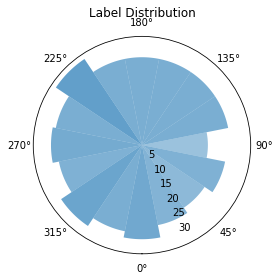

In [18]:
#Result Analysis1: Polar Histogramm
from scipy.interpolate import interp1d

#interpol = interp1d([min(labels), max(labels)], [0.4, 0.8])

bins_number = 16  # the [0, 2pi] interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
n, _, _ = plt.hist(labels, bins)

interpol = interp1d([0, max(n)], [0, 0.7])

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
d_alpha = 0.03
alpha = 0.4
count = 0
for bar in bars:
    bar.set_alpha(interpol(n[count]))
    alpha += d_alpha
    count += 1
ax.set_theta_zero_location("S")
#ax.set_theta_direction(-1)
ax.set_title("Label Distribution", va='bottom')
ax.grid(False)
#ax.set_rticks([1, 2, 3, 4])
plt.show()